---
**Module 1 Final Project Submission**
* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Project review date/time: **November 4, 2019 at 2:00 PM PST**
* Instructor name: **James Irving, PhD**
---
> Blog post URL: 
http://www.hakkeray.com/projects/datascience/2019/11/06/predicting-home-values-with-multiple-linear-regression.html

> Link to tableau public: https://public.tableau.com/views/HousePricesbyZipCodeinKingCountyWA/KingCounty?:display_count=y&:origin=viz_share_link

**GOAL**
* Identify best combination of variable(s) for predicting property values in King County, Washington, USA. 

**OBJECTIVES**
* Address null, missing, duplicate, and unreliable values in the data.
* Determine best approach for analyzing each feature: continuous vs. categorical values
* Identify which combination of features (X) are the best predictors of the target (y). 

**QUESTIONS TO EXPLORE**
* *Scrub*
    * 1. How should we address each feature to prepare it for EDA?
 
* *Explore*
    * 2. Which predictors are closely related (and should be dropped)?
    * 3. Is there an overlap in square-footage measurements?
    * 4. Can we combine two features into one to achieve a higher correlation?
    * 5. Does geography (location) have any relationship with the values of each categorical variable?
 
* *Model*
    * 6. Which features are the best candidates for predicting property values?
    * 7. Does removing outliers improve the distribution?
    * 8. Does scaling/transforming variables improve the regression algorithm?

**TABLE OF CONTENTS**

**[1  OBTAIN]**
Import libraries, packages, data set
* 1.1 Import libraries and packages
* 1.2 Import custom functions
* 1.3 Import dataset and review columns, variables

**[2  SCRUB]**
Clean and organize the data.
* 2.1 Find and replace missing values (nulls)
* 2.2 Identify/Address characteristics of each variable (numeric vs categorical) 
* 2.3 Check for and drop any duplicate observations (rows)
* 2.4 Decide which variables to keep for EDA

**[3  EXPLORE]**
Preliminary analysis and visualizations.
* 3.1 Linearity: Scatterplots, scattermatrix
* 3.2 Multicollinearity: Heatmaps, scatterplots
* 3.3 Distribution: Histograms, Kernel Density Estimates (KDE), LMplots, Boxplots
* 3.4 Regression: regression plots

**[4  MODEL]**
Iterate through linreg models to find best fit predictors
* 4.1 Model 1: OLS Linear Regression
* 4.2 Model 2: One-Hot Encoding
* 4.3 Model 3: Error terms
* 4.4 Model 4: QQ Plots
* 4.5 Model 5: Outliers
* 4.6 Model 6: Robust Scaler

**[5  VALIDATION]**
Validate the results.
* 5.1 K-Fold Cross Validation

**[6  INTERPRET]**
Summarize the findings and make recommendations.
* 6.1 Briefly summarize the results of analysis
* 6.2 Make recommendations
* 6.3 Describe possible future directions

**[7  Additional Research]**
Extracting median home values based on zipcodes

---
# OBTAIN

## Import libraries + packaes

In [ ]:
# import PyPi package for cohort libraries 
# comment out after install so it won't run again
!pip install -U fsds_100719

In [ ]:
# for the zip_stats() lookup function
!pip install uszipcode

In [1]:
# Import packages
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('seaborn-bright')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler

#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

fsds_1007219  v0.7.20 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


[i] Pandas .iplot() method activated.


## Import custom functions

Custom helper functions I wrote for this project are in the `functions.py` file.

- hot_stats()
- null_hunter()
- corrcoef_dict()
- sub_scatter()
- sub_hists()
- plot_reg()


In [2]:
from functions import *

## Import Data

In [3]:
# import dataset and review data types, columns, variables
df = pd.read_csv('kc_house_data.csv') 
df.head()

id        date     price  bedrooms  ...      lat     long  sqft_living15  sqft_lot15
0  7129300520  10/13/2014  221900.0         3  ...  47.5112 -122.257           1340        5650
1  6414100192   12/9/2014  538000.0         3  ...  47.7210 -122.319           1690        7639
2  5631500400   2/25/2015  180000.0         2  ...  47.7379 -122.233           2720        8062
3  2487200875   12/9/2014  604000.0         4  ...  47.5208 -122.393           1360        5000
4  1954400510   2/18/2015  510000.0         3  ...  47.6168 -122.045           1800        7503

[5 rows x 21 columns]

---
# SCRUB 

Clean and organize the data.

**FIRST GLANCE - Items to note**
    * There are 2 object datatypes that contain numeric values : 'date', 'sqft_basement'
    * The total value count is 21597. Some columns appear to be missing a substantial amount of data 
    (waterfront and yr_renovated).

In [4]:
# Display information about the variables, columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Before going further, a little house-keeping is in order. Let's breakdown the columns into groups based on feature-type as they relate to a real estate market context:

*Dependent Variable:*

TARGET
**price**

*Independent Variables:*

INTERIOR
**bedrooms, bathrooms, floors**

SIZE (SQUARE FOOTAGE)
**sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15**

LOCATION
**zipcode, lat, long, waterfront**

QUALITY
**condition, grade, yr_built, yr_renovated**

ANALYTICS
**date, id, view**

## Missing Values
Find and replace missing values using null_hunter() function.

In [5]:
# hunt for nulls
null_hunter(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



Before deciding how to handle nulls in the 3 columns above, let's take a closer look at each one and go from there.

## Data Casting

Identify/Address characteristics of each variable (numeric vs categorical)

### ['waterfront']

In [6]:
hot_stats(df, 'waterfront')

-------->
HOT!STATS
<--------

WATERFRONT
Data Type: float64

count    19221.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: waterfront, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
2376 Nulls out of 21597(11.0%)

Non-Null Value Counts:
0.0    19075
1.0      146
Name: waterfront, dtype: int64

# Unique Values: 3



In [7]:
# Fill nulls with most common value (0.0) # float value
df['waterfront'].fillna(0.0, inplace=True)
#  verify changes
df['waterfront'].isna().sum()

0

In [8]:
# Convert datatype to boolean (values can be either 0 (not waterfront) or 1(is waterfront)
df['is_wf'] = df['waterfront'].astype('bool')
# verify
df['is_wf'].value_counts()

False    21451
True       146
Name: is_wf, dtype: int64

### ['yr_renovated']

In [9]:
hot_stats(df, 'yr_renovated')

-------->
HOT!STATS
<--------

YR_RENOVATED
Data Type: float64

count    17755.00
mean        83.64
std        399.95
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       2015.00
Name: yr_renovated, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
3842 Nulls out of 21597(17.79%)

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

# Unique Values: 71



In [10]:
# This feature is also heavily skewed with zero values. 
# It should also be treated as a boolean since a property is either renovated or it's not).

# fill nulls with most common value (0)
df['yr_renovated'].fillna(0.0, inplace=True) # use float value to match current dtype

# verify change
df['yr_renovated'].isna().sum()

0

In [11]:
# Use numpy arrays to create binarized column 'is_renovated'
is_renovated = np.array(df['yr_renovated'])
is_renovated[is_renovated >= 1] = 1
df['is_ren'] = is_renovated
df['is_ren'].value_counts()

0.0    20853
1.0      744
Name: is_ren, dtype: int64

In [12]:
# Convert to boolean
df['is_ren'] = df['is_ren'].astype('bool')

# verify
df['is_ren'].value_counts()

False    20853
True       744
Name: is_ren, dtype: int64

### ['view']

In [13]:
hot_stats(df, 'view')

-------->
HOT!STATS
<--------

VIEW
Data Type: float64

count    21534.00
mean         0.23
std          0.77
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: view, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
63 Nulls out of 21597(0.29%)

Non-Null Value Counts:
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

# Unique Values: 6



In [14]:
# Once again, almost all values are 0 .0

# replace nulls with most common value (0). 
df['view'].fillna(0, inplace=True)

#verify
df['view'].isna().sum()

0

Since view has a finite set of values (0 to 4) we could assign category codes. However, considering the high number of zeros, it makes more sense to binarize the values into a new column representing whether or not the property was viewed.

In [15]:
# create new boolean column for view:
df['viewed'] = df['view'].astype('bool')

# verify
df['viewed'].value_counts()

False    19485
True      2112
Name: viewed, dtype: int64

### ['sqft_basement']

In [16]:
hot_stats(df, 'sqft_basement')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: object

min    0.0
max      ?
Name: sqft_basement, dtype: object 

à-la-Mode: 
0    0.0
dtype: object


No Nulls Found!

Non-Null Value Counts:
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
946.0         1
1770.0        1
1008.0        1
861.0         1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

# Unique Values: 304



In [17]:
# Note the majority of the values are zero...we could bin this as a binary 
# where the property either has a basement or does not...

# First replace '?'s with string value '0.0'
df['sqft_basement'].replace(to_replace='?', value='0.0', inplace=True)

In [18]:
# and change datatype to float.
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [19]:
hot_stats(df, 'sqft_basement', t='price')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: float64

count    21597.00
mean       285.72
std        439.82
min          0.00
25%          0.00
50%          0.00
75%        550.00
max       4820.00
Name: sqft_basement, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

# Unique Values: 303

Correlation with PRICE: 0.3211


In [20]:
df['basement'] = df['sqft_basement'].astype('bool')

In [21]:
df['basement'].value_counts()

False    13280
True      8317
Name: basement, dtype: int64

In [22]:
corrs = ['is_wf', 'is_ren', 'viewed', 'basement']

# check correlation coefficients
corr_dict(df, corrs, 'price')

{'is_wf': 0.26430628048311555,
 'is_ren': 0.11754308700194359,
 'viewed': 0.3562431893938027,
 'basement': 0.1782635193205336}

None of these correlation values look strong enough to be predictive of price (min threshold > 0.5, ideally 0.7)

### ['floors']

In [23]:
hot_stats(df, 'floors', t='price')

-------->
HOT!STATS
<--------

FLOORS
Data Type: float64

count    21597.00
mean         1.49
std          0.54
min          1.00
25%          1.00
50%          1.50
75%          2.00
max          3.50
Name: floors, dtype: float64 

à-la-Mode: 
0    1.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

# Unique Values: 6

Correlation with PRICE: 0.2568


Bathrooms appears to have a very linear relationship with price. Bedrooms is somewhat linear up to a certain point. Let's look at the hot stats for both.

### ['bedrooms']

In [24]:
hot_stats(df, 'bedrooms', t='price')

-------->
HOT!STATS
<--------

BEDROOMS
Data Type: int64

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64 

à-la-Mode: 
0    3
dtype: int64


No Nulls Found!

Non-Null Value Counts:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Unique Values: 12

Correlation with PRICE: 0.3088


### ['bathrooms']

In [25]:
hot_stats(df, 'bathrooms', t='price')

-------->
HOT!STATS
<--------

BATHROOMS
Data Type: float64

count    21597.00
mean         2.12
std          0.77
min          0.50
25%          1.75
50%          2.25
75%          2.50
max          8.00
Name: bathrooms, dtype: float64 

à-la-Mode: 
0    2.5
dtype: float64


No Nulls Found!

Non-Null Value Counts:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

# Unique Values: 29

Correlation with PRICE: 0.5259


Bathrooms is the only feature showing correlation over the 0.5 threshold.

The column-like distributions of these features in the scatterplots below indicate the values are categorical.

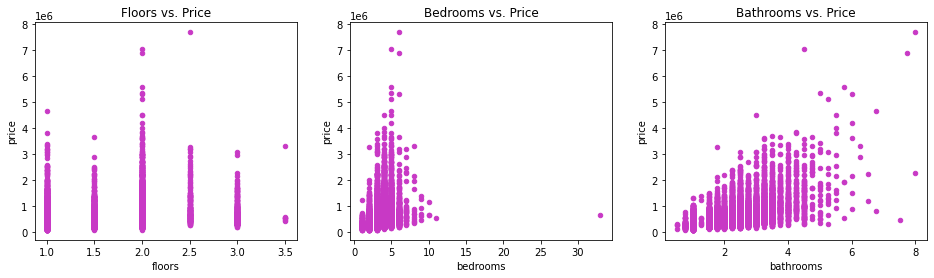

In [26]:
# sub_scatter() creates scatter plots for multiple features side by side.
y = 'price'
x_cols = ['floors','bedrooms', 'bathrooms']

sub_scatter(df, x_cols, y)

Looking at each one more closely using seaborn's catplot:

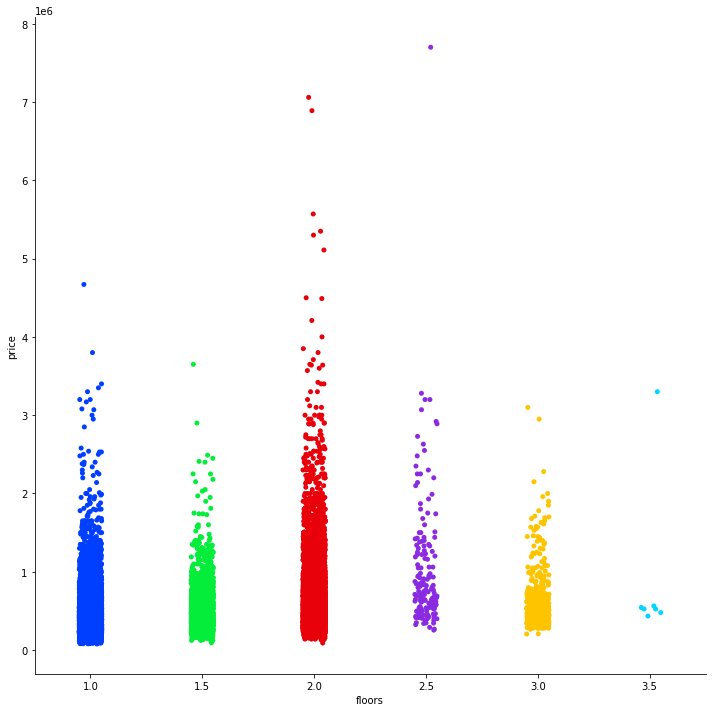

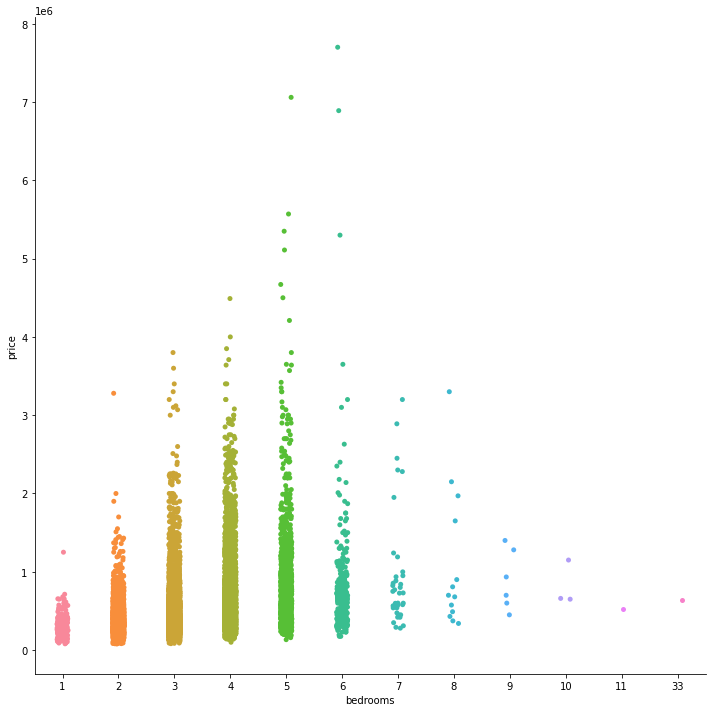

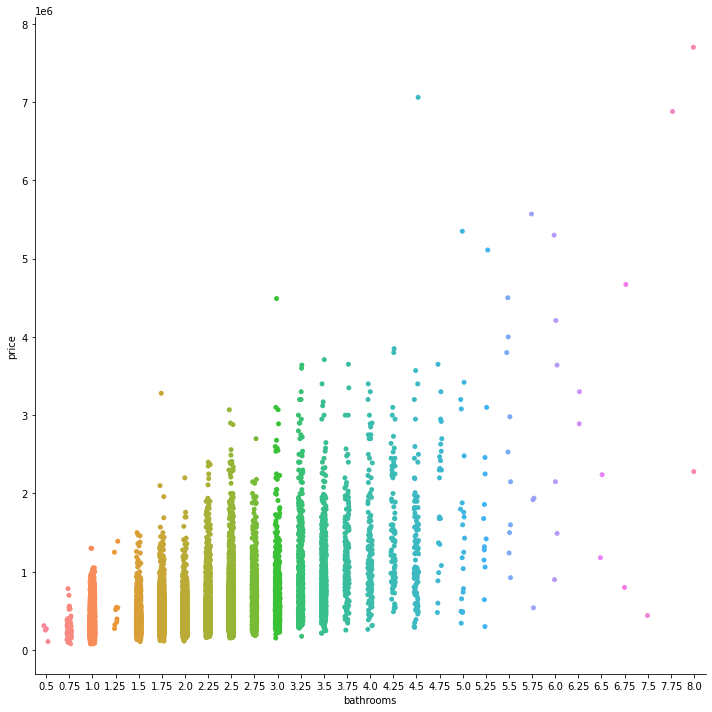

In [27]:
for col in x_cols:
    sns.catplot(x=col, y='price', height=10, legend=True, data=df)

In [28]:
# save correlation coefficients higher than 0.5 in a dict
corr_thresh_dict = {}
corrs = ['bathrooms']
corr_thresh_dict = corr_dict(df, corrs, 'price')
corr_thresh_dict

{'bathrooms': 0.5259056214532009}

### ['condition']

In [29]:
hot_stats(df, 'condition', t='price')

-------->
HOT!STATS
<--------

CONDITION
Data Type: int64

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64 

à-la-Mode: 
0    3
dtype: int64


No Nulls Found!

Non-Null Value Counts:
3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

# Unique Values: 5

Correlation with PRICE: 0.0361


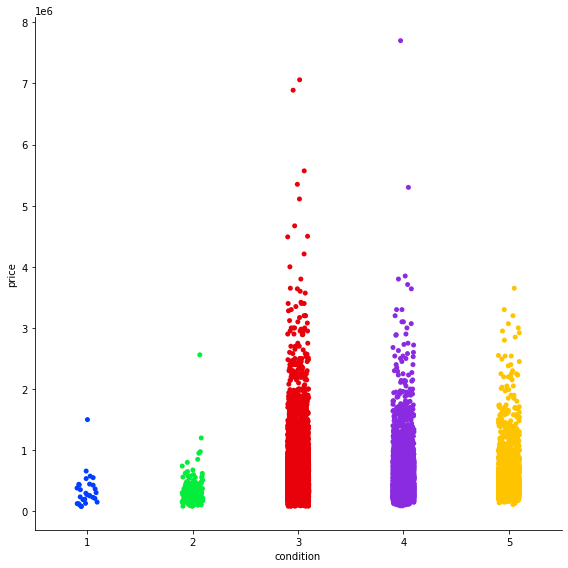

In [30]:
sns.catplot(x='condition', y='price', data=df, height=8)

Positive linear correlation between price and condition up to a point, but with diminishing returns.

### ['grade']

In [31]:
# View grade stats
hot_stats(df, 'grade', t='price')

-------->
HOT!STATS
<--------

GRADE
Data Type: int64

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64 

à-la-Mode: 
0    7
dtype: int64


No Nulls Found!

Non-Null Value Counts:
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

# Unique Values: 11

Correlation with PRICE: 0.668


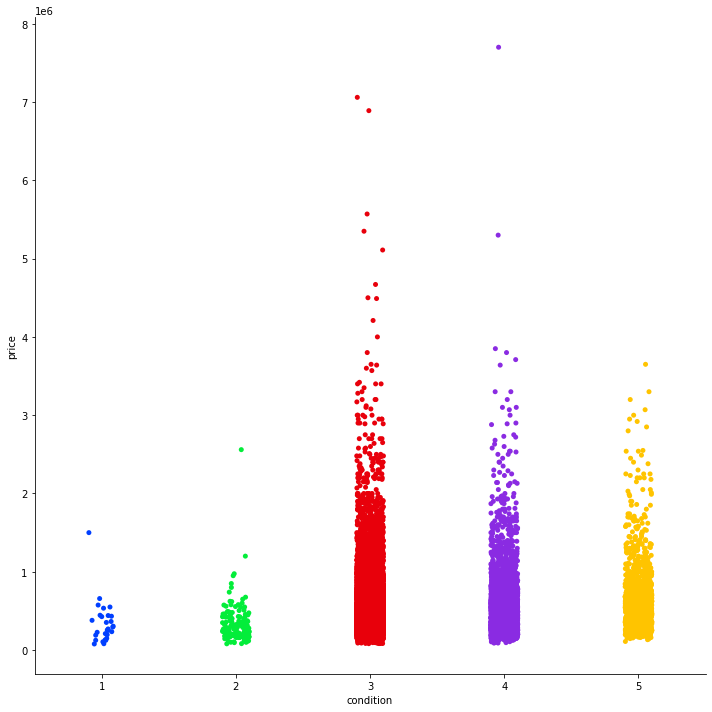

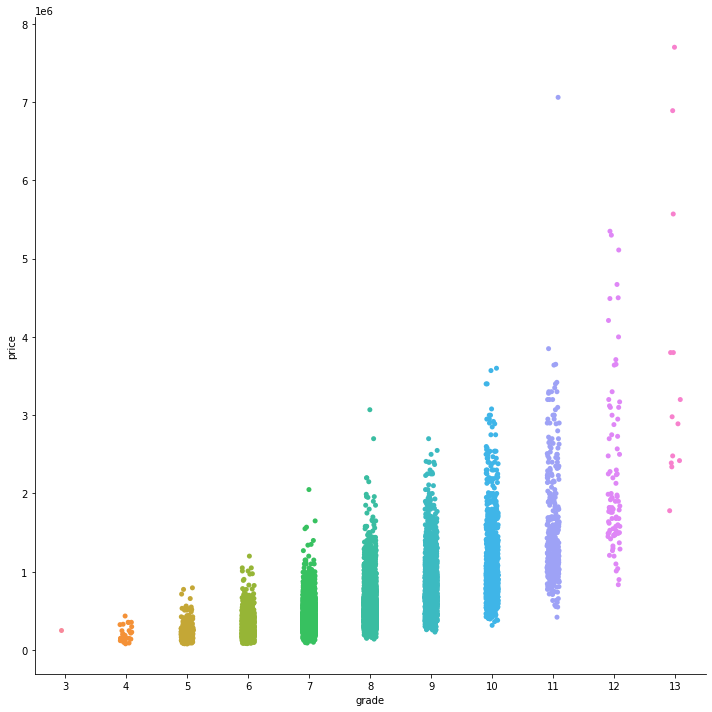

In [32]:
x_cols = ['condition', 'grade']
for col in x_cols:
    sns.catplot(x=col, y='price', height=10, legend=True, data=df)

Grade shows a relatively strong positive correlation with price.

### ['yr_built'] 

In [33]:
hot_stats(df, 'yr_built', t='price')

-------->
HOT!STATS
<--------

YR_BUILT
Data Type: int64

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64 

à-la-Mode: 
0    2014
dtype: int64


No Nulls Found!

Non-Null Value Counts:
2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

# Unique Values: 116

Correlation with PRICE: 0.054


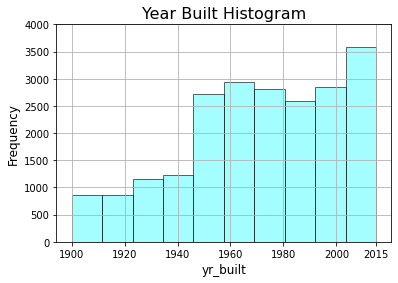

In [34]:
# Let's look at the data distribution of yr_built values 

fig, ax = plt.subplots()
df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
xticks = (1900, 1920, 1940, 1960, 1980, 2000, 2015)
yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
plt.xticks(xticks);
plt.yticks(yticks);
ax.set_title('Year Built Histogram', fontsize=16)
ax.set_xlabel('yr_built', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

Most houses were built during the second half of the century (after 1950). We'll use adaptive binning based on quantiles for yr_built in order to create a more normal distribution.

In [35]:
# define a binning scheme with custom ranges based on quantiles
quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['yr_built'].quantile(quantile_list)

quantiles # 1900, 1951, 1975, 1997, 2015

0.00    1900.0
0.25    1951.0
0.50    1975.0
0.75    1997.0
1.00    2015.0
Name: yr_built, dtype: float64

In [36]:
# Bin the years in to ranges based on the quantiles.
yb_bins = [1900, 1951, 1975, 1997, 2015]

# label the bins for each value 
yb_labels = [1, 2, 3, 4]

# store the yr_range and its corresponding yr_label as new columns in df

# create a new column for the category range values
df['yb_range'] = pd.cut(df['yr_built'], bins=yb_bins)

# create a new column for the category labels
df['yb_cat'] = pd.cut(df['yr_built'], bins=yb_bins, labels=yb_labels)

In [37]:
# view the binned features corresponding to each yr_built 
df[['yr_built','yb_cat', 'yb_range']].iloc[9003:9007] # picking a random index location

yr_built yb_cat      yb_range
9003      1996      3  (1975, 1997]
9004      1959      2  (1951, 1975]
9005      2003      4  (1997, 2015]
9006      1902      1  (1900, 1951]

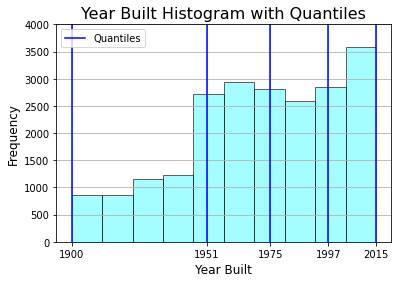

In [38]:
# Let’s look at the original distribution histogram again with the quantiles added:

fig, ax = plt.subplots()

df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='b')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    xticks = quantiles
    yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
    plt.xticks(xticks);
    plt.yticks(yticks);
    ax.set_title('Year Built Histogram with Quantiles',fontsize=16)
    ax.set_xlabel('Year Built', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [39]:
# values look much more normally distributed between the new categories
df.yb_cat.value_counts()

2    5515
3    5411
1    5326
4    5258
Name: yb_cat, dtype: int64

Text(0, 0.5, 'Frequency')

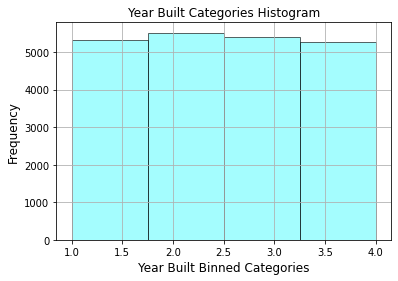

In [40]:
# visualize the distribution of the binned values

fig, ax = plt.subplots()
df['yb_cat'].hist(bins=4, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
ax.set_title('Year Built Categories Histogram', fontsize=12)
ax.set_xlabel('Year Built Binned Categories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

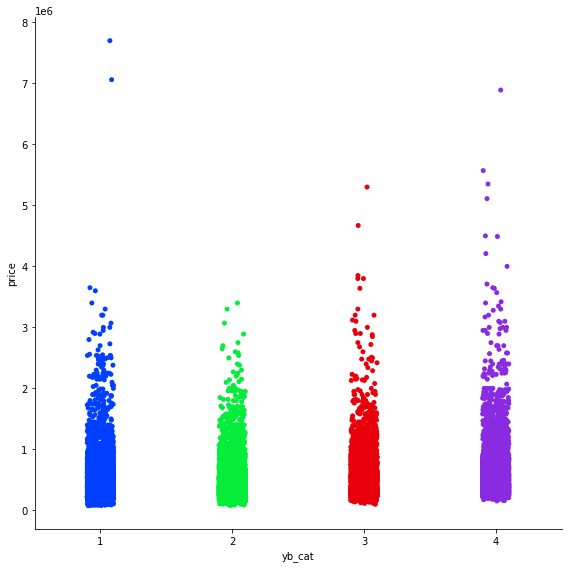

In [41]:
sns.catplot(x='yb_cat', y='price', data=df, height=8)

###  ['zipcode']

In [42]:
hot_stats(df, 'zipcode')

-------->
HOT!STATS
<--------

ZIPCODE
Data Type: int64

count    21597.000000
mean     98077.951845
std         53.513072
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64 

à-la-Mode: 
0    98103
dtype: int64


No Nulls Found!

Non-Null Value Counts:
98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

# Unique Values: 70



Text(0, 0.5, 'Frequency')

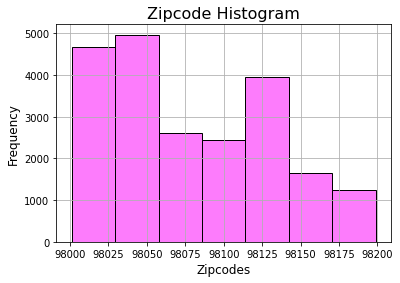

In [43]:
# Let's look at the data distribution of the 70 unique zipcode values 
fig, ax = plt.subplots()
df['zipcode'].hist(bins=7, color='#FD7CFC',
edgecolor='black', grid=True)
ax.set_title('Zipcode Histogram', fontsize=16)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [44]:
# Let’s define a binning scheme with custom ranges for the zipcode values 
# The bins will be created based on quantiles

quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['zipcode'].quantile(quantile_list)

quantiles # 98001, 98033, 98065, 98118, 98199

0.00    98001.0
0.25    98033.0
0.50    98065.0
0.75    98118.0
1.00    98199.0
Name: zipcode, dtype: float64

In [45]:
# Now we can label the bins for each value and store both the bin range 
# and its corresponding label.

zip_bins = [98000, 98033, 98065, 98118, 98200]

zip_labels = [1, 2, 3, 4]

df['zip_range'] = pd.cut(df['zipcode'], bins=zip_bins)

df['zip_cat'] = pd.cut(df['zipcode'], bins=zip_bins, labels=zip_labels)

# view the binned features 
df[['zipcode','zip_cat', 'zip_range']].iloc[9000:9005] # pick a random index

zipcode zip_cat       zip_range
9000    98092       3  (98065, 98118]
9001    98117       3  (98065, 98118]
9002    98144       4  (98118, 98200]
9003    98038       2  (98033, 98065]
9004    98004       1  (98000, 98033]

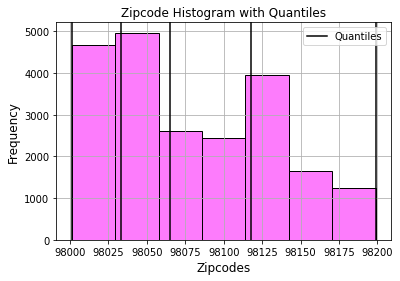

In [46]:
# visualize the quantiles in the original distribution histogram

fig, ax = plt.subplots()

df['zipcode'].hist(bins=7, color='#FD7CFC', edgecolor='black', grid=True)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='black')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Zipcode Histogram with Quantiles',fontsize=12)
    ax.set_xlabel('Zipcodes', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

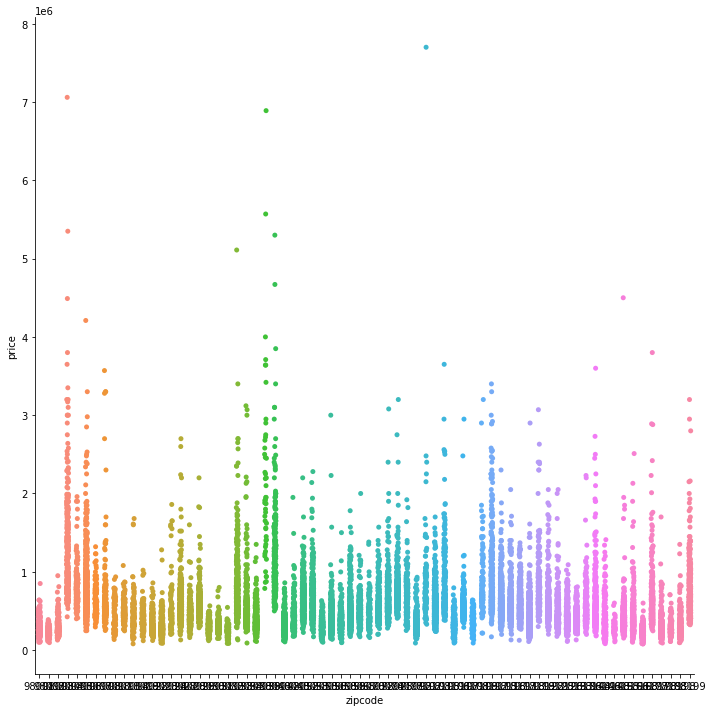

In [47]:
sns.catplot(x='zipcode', y='price', data=df, height=10)

> Some zip codes may have higher priced homes than others, so it's hard to determine from the catplot how this could be used as a predictor. We'll have to explore this variable using geographic plots to see how the distributions trend on a map (i.e. proximity).

### ['lat']  ['long']

> The coordinates for latitude and longitude are not going to be useful to us as far as regression models since we already have zipcodes as a geographic identifier. However we can put them to use for our geographic plotting.

### ['date'] 
convert to datetime

In [48]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [49]:
hot_stats(df, 'date', t='price')

-------->
HOT!STATS
<--------

DATE
Data Type: datetime64[ns]

min   2014-05-02
max   2015-05-27
Name: date, dtype: datetime64[ns] 

à-la-Mode: 
0   2014-06-23
dtype: datetime64[ns]


No Nulls Found!

Non-Null Value Counts:
2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
             ... 
2014-07-27      1
2015-03-08      1
2014-11-02      1
2015-05-15      1
2015-05-24      1
Name: date, Length: 372, dtype: int64

# Unique Values: 372



### ['sqft_above']

In [50]:
hot_stats(df, 'sqft_above', t='price')

-------->
HOT!STATS
<--------

SQFT_ABOVE
Data Type: int64

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64 

à-la-Mode: 
0    1300
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

# Unique Values: 942

Correlation with PRICE: 0.6054


    Some correlation with price here!

### ['sqft_living']

In [51]:
hot_stats(df, 'sqft_living', t='price')

-------->
HOT!STATS
<--------

SQFT_LIVING
Data Type: int64

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64 

à-la-Mode: 
0    1300
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

# Unique Values: 1034

Correlation with PRICE: 0.7019


sqft_living shows correlation value of 0.7 with price -- our highest coefficient yet!

### ['sqft_lot']

In [52]:
hot_stats(df, 'sqft_lot', t='price')

-------->
HOT!STATS
<--------

SQFT_LOT
Data Type: int64

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64 

à-la-Mode: 
0    5000
dtype: int64


No Nulls Found!

Non-Null Value Counts:
5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

# Unique Values: 9776

Correlation with PRICE: 0.0899


### ['sqft_living15']

In [53]:
hot_stats(df, 'sqft_living15', t='price')

-------->
HOT!STATS
<--------

SQFT_LIVING15
Data Type: int64

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64 

à-la-Mode: 
0    1540
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

# Unique Values: 777

Correlation with PRICE: 0.5852


We've identified another coefficient over the 0.5 correlation threshold.

In [54]:
hot_stats(df, 'sqft_lot15', t='price')

-------->
HOT!STATS
<--------

SQFT_LOT15
Data Type: int64

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64 

à-la-Mode: 
0    5000
dtype: int64


No Nulls Found!

Non-Null Value Counts:
5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

# Unique Values: 8682

Correlation with PRICE: 0.0828


## Duplicates

The primary key we'd use as an index for this data set would be 'id'. Our assumption therefore is that the 'id' for each observation (row) is unique. Let's do a quick scan for duplicate entries to confirm this is true.

### ['id']

In [55]:
hot_stats(df, 'id')

-------->
HOT!STATS
<--------

ID
Data Type: int64

count    2.159700e+04
mean     4.580474e+09
std      2.876736e+09
min      1.000102e+06
25%      2.123049e+09
50%      3.904930e+09
75%      7.308900e+09
max      9.900000e+09
Name: id, dtype: float64 

à-la-Mode: 
0    795000620
dtype: int64


No Nulls Found!

Non-Null Value Counts:
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

# Unique Values: 21420



In [56]:
# check for duplicate id's
df['id'].duplicated().value_counts() 

False    21420
True       177
Name: id, dtype: int64

In [57]:
# Looks like there are in fact some duplicate ID's! Not many, but worth investigating.

# Let's flag the duplicate id's by creating a new column 'is_dupe':
df.loc[df.duplicated(subset='id', keep=False), 'is_dupe'] = 1 # mark all duplicates 

# verify all duplicates were flagged
df.is_dupe.value_counts() # 353

1.0    353
Name: is_dupe, dtype: int64

In [58]:
# the non-duplicate rows show as null in our new column
df.is_dupe.isna().sum()

21244

In [59]:
# Replace 'nan' rows in is_dupe with 0.0
df.loc[df['is_dupe'].isna(), 'is_dupe'] = 0

# verify
df['is_dupe'].unique()

array([0., 1.])

In [60]:
# convert column to boolean data type
df['is_dupe'] = df['is_dupe'].astype('bool')
# verify
df['is_dupe'].value_counts()

False    21244
True       353
Name: is_dupe, dtype: int64

In [61]:
# Let's now copy the duplicates into a dataframe subset for closer inspection
# It's possible the pairs contain data missing from the other which 
# we can use to fill nulls identified previously.

df_dupes = df.loc[df['is_dupe'] == True]

# check out the data discrepancies between duplicates (first 3 pairs)
df_dupes.head(6)

id       date      price  bedrooms  ...  yb_cat       zip_range  zip_cat  is_dupe
93   6021501535 2014-07-25   430000.0         3  ...       1  (98065, 98118]        3     True
94   6021501535 2014-12-23   700000.0         3  ...       1  (98065, 98118]        3     True
313  4139480200 2014-06-18  1380000.0         4  ...       3  (98000, 98033]        1     True
314  4139480200 2014-12-09  1400000.0         4  ...       3  (98000, 98033]        1     True
324  7520000520 2014-09-05   232000.0         2  ...       1  (98118, 98200]        4     True
325  7520000520 2015-03-11   240500.0         2  ...       1  (98118, 98200]        4     True

[6 rows x 30 columns]

In [62]:
# Looks like the only discrepancies might occur between 'date' and 'price' values
# Some of the prices nearly double, even when the re-sale is just a few months later!

df_dupes.loc[df_dupes['id'] == 6021501535]

id       date     price  bedrooms  ...  yb_cat       zip_range  zip_cat  is_dupe
93  6021501535 2014-07-25  430000.0         3  ...       1  (98065, 98118]        3     True
94  6021501535 2014-12-23  700000.0         3  ...       1  (98065, 98118]        3     True

[2 rows x 30 columns]

In [63]:
# Set index of df_dupes to 'id'
df_dupes.set_index('id')
# Set index of df to 'id'
df.set_index('id')

date     price  bedrooms  bathrooms  ...  yb_cat       zip_range  zip_cat  is_dupe
id                                                    ...                                          
7129300520 2014-10-13  221900.0         3       1.00  ...       2  (98118, 98200]        4    False
6414100192 2014-12-09  538000.0         3       2.25  ...       1  (98118, 98200]        4    False
5631500400 2015-02-25  180000.0         2       1.00  ...       1  (98000, 98033]        1    False
2487200875 2014-12-09  604000.0         4       3.00  ...       2  (98118, 98200]        4    False
1954400510 2015-02-18  510000.0         3       2.00  ...       3  (98065, 98118]        3    False
...               ...       ...       ...        ...  ...     ...             ...      ...      ...
263000018  2014-05-21  360000.0         3       2.50  ...       4  (98065, 98118]        3    False
6600060120 2015-02-23  400000.0         4       2.50  ...       4  (98118, 98200]        4    False
1523300141 2014-06-23  402101.0         2       0.75  ...       4  (98118, 98200]        4    False
291310100  2015-01-16  400000.0         3       2.50  ...       4  (98000, 98033]        1    False
1523300157 2014-10-15  325000.0         2       0.75  ...       4  (98118, 98200]        4    False

[21597 rows x 29 columns]

In [64]:
# Before we drop the duplicates, let's save a backup copy of the current df using pickle.
import pickle
# create pickle data_object
df_predrops = df

In [65]:
with open('data.pickle', 'wb') as f:
    pickle.dump(df_predrops, f, pickle.HIGHEST_PROTOCOL)

In [66]:
#import df (pre-drops) with pickle
#with open('data.pickle', 'rb') as f:
#    df = pickle.load(f)

In [67]:
# let's drop the first occurring duplicate rows and keep the last ones 
# (since those more accurately reflect latest market data)

# save original df.shape for comparison after dropping duplicate rows
predrop = df.shape # (21597, 28)

# first occurrence, keep last
df.drop_duplicates(subset='id', keep ='last', inplace = True) 

# verify dropped rows by comparing df.shape before and after values
print(f"predrop: {predrop}")
print(f"postdrop: {df.shape}")

predrop: (21597, 30)
postdrop: (21420, 30)


## Target

#### ['price']

In [68]:
# Let's take a quick look at the statistical data for our dependent variable (price):
hot_stats(df, 'price')

-------->
HOT!STATS
<--------

PRICE
Data Type: float64

count      21420.00
mean      541861.43
std       367556.94
min        78000.00
25%       324950.00
50%       450550.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64 

à-la-Mode: 
0    450000.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
450000.0    172
350000.0    167
550000.0    157
500000.0    151
425000.0    149
           ... 
234975.0      1
804995.0      1
870515.0      1
336950.0      1
884744.0      1
Name: price, Length: 3595, dtype: int64

# Unique Values: 3595



> Keeping the below numbers in mind could be helpful as we start exploring the data:

* range: 78,000 to 7,700,000
* mean value: 540,296
* median value: 450,000

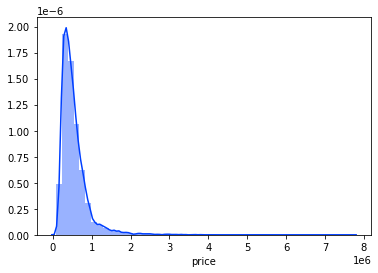

In [69]:
# long tails in price and the median is lower than the mean - distribution is skewed to the right
sns.distplot(df.price)

At this point we can begin exploring the data. Let's first review our current feature list and get rid of any columns we no longer need. As we go through our analysis we'll decide which additional columns to drop, transform, scale, normalize, etc.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 30 columns):
id               21420 non-null int64
date             21420 non-null datetime64[ns]
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
yr_built         21420 non-null int64
yr_renovated     21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_wf            21420 non-null bool
is_ren           21420 non-nu

In [71]:
# cols to drop bc irrelevant to linreg model or using new versions instead:
hot_drop = ['date','id','waterfront', 'yr_renovated', 'view', 'yr_built', 'yb_range', 'zip_range']

In [72]:
# store hot_drop columns in separate df
df_drops = df[hot_drop].copy()

In [73]:
# set index of df_drops to 'id'
df_drops.set_index('id')
# verify
df_drops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 8 columns):
date            21420 non-null datetime64[ns]
id              21420 non-null int64
waterfront      21420 non-null float64
yr_renovated    21420 non-null float64
view            21420 non-null float64
yr_built        21420 non-null int64
yb_range        21334 non-null category
zip_range       21420 non-null category
dtypes: category(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.2 MB


In [74]:
# drop it like its hot >> df.drop(hot_drop, axis=1, inplace=True)
df.drop(hot_drop, axis=1, inplace=True)

# verify dropped columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 22 columns):
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_wf            21420 non-null bool
is_ren           21420 non-null bool
viewed           21420 non-null bool
basement         21420 non-null bool
yb_cat           21334 non-null category
zip_cat          21420 non-null category
is_dupe          21420 non-null bool
dtypes: bool(5), category(2), float64(6), 

# EXPLORE:
    
    EDA CHECKLIST:
    linearity (scatter matrices)
    multicollinearity (heatmaps)
    distributions (histograms, KDEs)
    regression (regplot)

**QUESTION: Which features are the best candidates for predicting property values?**

In [75]:
df.describe()

price      bedrooms     bathrooms  ...          long  sqft_living15     sqft_lot15
count  2.142000e+04  21420.000000  21420.000000  ...  21420.000000   21420.000000   21420.000000
mean   5.418614e+05      3.373950      2.118429  ...   -122.213784    1988.384080   12775.718161
std    3.675569e+05      0.925405      0.768720  ...      0.140791     685.537057   27345.621867
min    7.800000e+04      1.000000      0.500000  ...   -122.519000     399.000000     651.000000
25%    3.249500e+05      3.000000      1.750000  ...   -122.328000    1490.000000    5100.000000
50%    4.505500e+05      3.000000      2.250000  ...   -122.230000    1840.000000    7620.000000
75%    6.450000e+05      4.000000      2.500000  ...   -122.125000    2370.000000   10086.250000
max    7.700000e+06     33.000000      8.000000  ...   -121.315000    6210.000000  871200.000000

[8 rows x 15 columns]

## Linearity
During the scrub process we made some assumptions and guesses based on correlation coefficients and other values. Let's see what the visualizations tell us by creating some scatter plots.

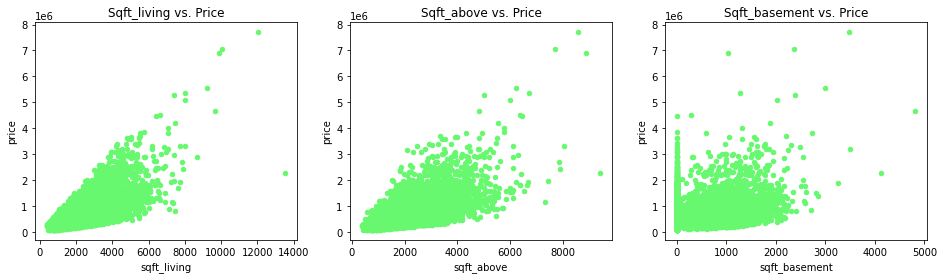

In [76]:
# Visualize the relationship between square-footages and price
sqft_int = ['sqft_living', 'sqft_above', 'sqft_basement']
sub_scatter(df, sqft_int, 'price', color='#67F86F') #20C5C6

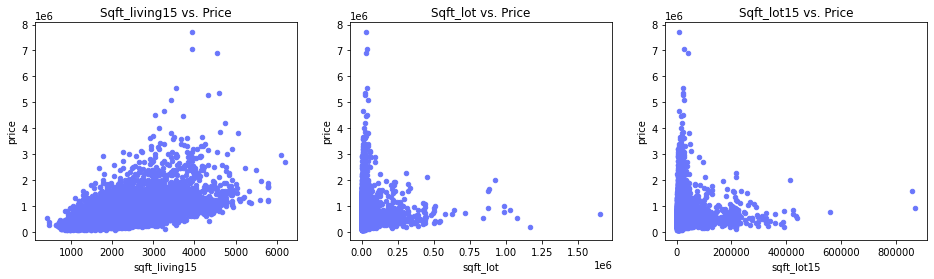

In [77]:
# visualize relationship between sqft_lot, sqft_lot15, sqft_living15 and price.
y = 'price'
sqft_ext = ['sqft_living15', 'sqft_lot', 'sqft_lot15']

sub_scatter(df, sqft_ext, y, color='#6A76FB')

Linear relationships with price show up clearly for sqft_living, sqft_above, sqft_living15.

## Multicollinearity
**QUESTION: which predictors are closely related (and should be dropped)?**

    + multicollinearity: remove variable having most corr with largest # of variables

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2f4d4bd0>)

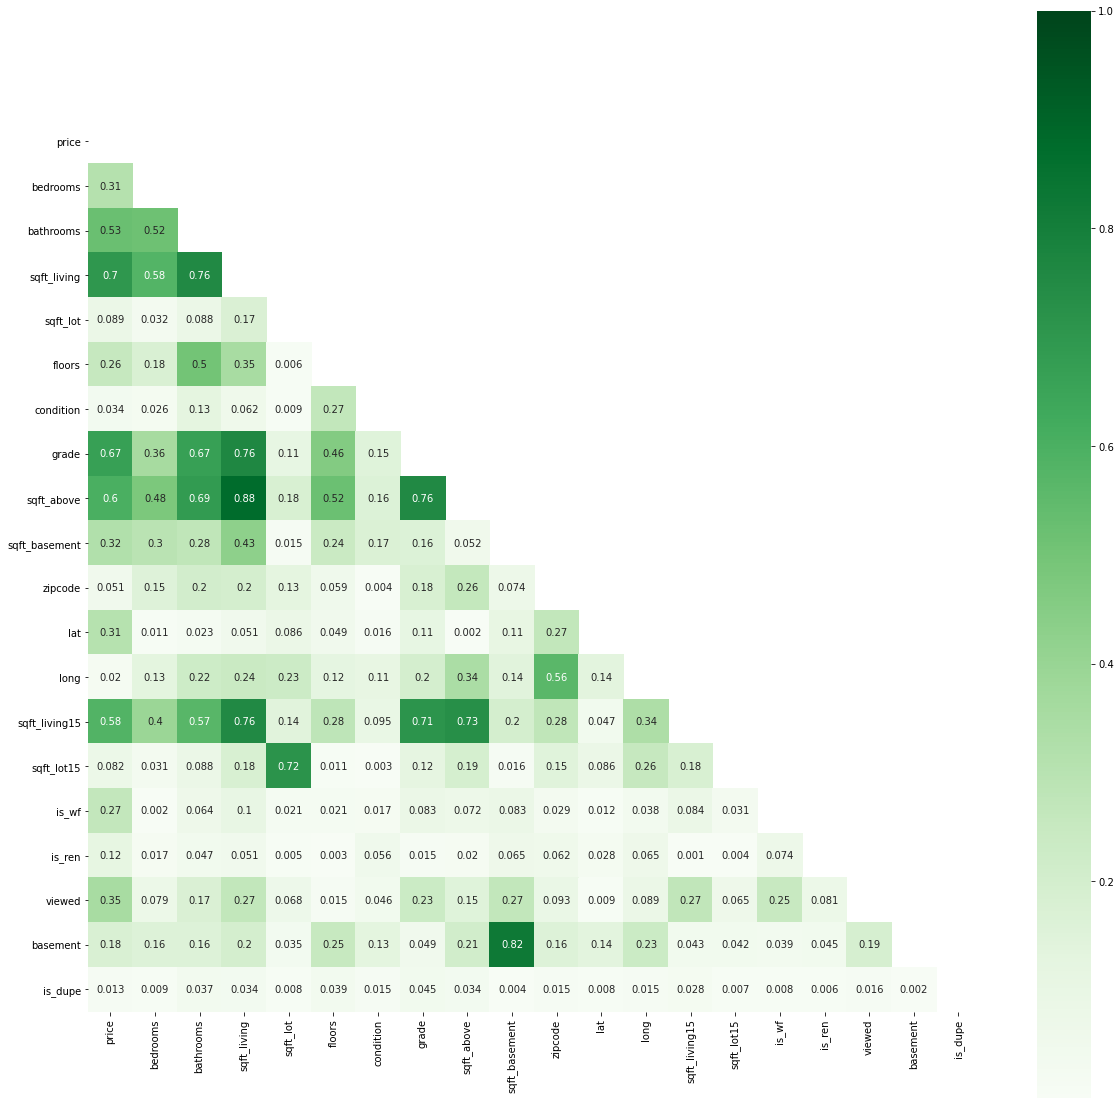

In [78]:
#correlation values to check

corr = df.corr()

# Checking multicollinearity with a heatmap
def multiplot(corr,figsize=(20,20)):
    fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(corr, dtype=np.bool)
    idx = np.triu_indices_from(mask)
    mask[idx] = True

    sns.heatmap(np.abs(corr),square=True,mask=mask,annot=True,cmap="Greens",ax=ax)
    
    ax.set_ylim(len(corr), -.5, .5)
    
    
    return fig, ax

multiplot(np.abs(corr.round(3)))

The square footages probably overlap. (In other words sqft_above and sqft_basement could be part of the total sqft_living measurement).

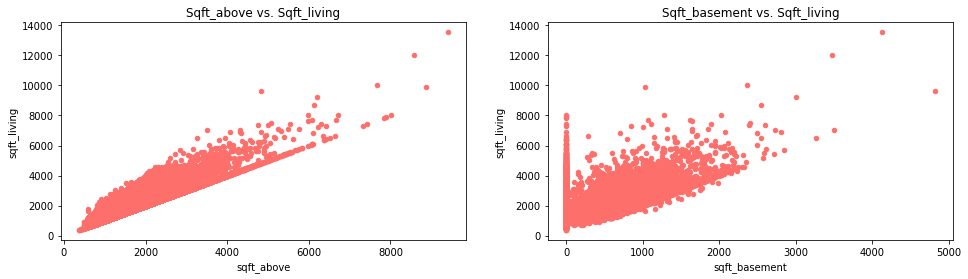

In [79]:
# Visualize multicollinearity between interior square-footages
x_cols = ['sqft_above', 'sqft_basement']
sub_scatter(df, x_cols, 'sqft_living', ncols = 2, color='#FD6F6B')  # lightred

    Yikes. These are extremely linear. Just for fun, let's crunch the numbers...

**QUESTION: Is there any overlap in square-footage measurements?**

In [80]:
# create new col containing sum of above and basement
df['sqft_sums'] = df['sqft_above'] + df['sqft_basement']
df['sqft_diffs'] = df['sqft_living'] - df['sqft_above']


sqft_cols = ['sqft_sums', 'sqft_living', 'sqft_above','sqft_diffs', 'sqft_basement']
df_sqft = df[sqft_cols]
df_sqft

sqft_sums  sqft_living  sqft_above  sqft_diffs  sqft_basement
0         1180.0         1180        1180           0            0.0
1         2570.0         2570        2170         400          400.0
2          770.0          770         770           0            0.0
3         1960.0         1960        1050         910          910.0
4         1680.0         1680        1680           0            0.0
...          ...          ...         ...         ...            ...
21592     1530.0         1530        1530           0            0.0
21593     2310.0         2310        2310           0            0.0
21594     1020.0         1020        1020           0            0.0
21595     1600.0         1600        1600           0            0.0
21596     1020.0         1020        1020           0            0.0

[21420 rows x 5 columns]

> Looks like the 0.0 values in sqft_basement do in fact mean there is no basement, and for those houses the sqft_above is exactly the same as sqft_living. With this now confirmed, we can be confident that sqft_living is the only measurement worth keeping for analysis.

In [81]:
# check random location in the index
print(df['sqft_living'].iloc[0]) #1180
print(df['sqft_above'].iloc[0] + df['sqft_basement'].iloc[0]) #1180

print(df['sqft_living'].iloc[1]) #2570
print(df['sqft_above'].iloc[1] + df['sqft_basement'].iloc[1]) #2570

1180
1180.0
2570
2570.0


In [82]:
# sqft_living == sqft_basement + sqft_above ?
# sqft_lot - sqft_living == sqft_above ?

sqft_lv = np.array(df['sqft_living'])
sqft_ab = np.array(df['sqft_above'])
sqft_bs = np.array(df['sqft_basement'])

sqft_ab + sqft_bs == sqft_lv #array([ True,  True,  True, ...,  True,  True,  True])

array([ True,  True,  True, ...,  True,  True,  True])

In [83]:
# check them all at once
if sqft_ab.all() + sqft_bs.all() == sqft_lv.all():
    print("True")

True


**ANSWER: Yes. Sqft_living is the sum of sqft_above and sqft_basement.**

## Distributions

In [84]:
# group cols kept for EDA into lists for easy extraction

# binned:
bins = ['is_wf', 'is_ren', 'viewed','basement', 'yb_cat', 'zip_cat', 'is_dupe']

# categorical:
cats = ['grade', 'condition', 'bathrooms', 'bedrooms', 'floors']

#numeric:
nums = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'sqft_lot15']

# geographic:
geo = ['lat', 'long', 'zipcode']

# target variable
t = ['price']

### Histograms

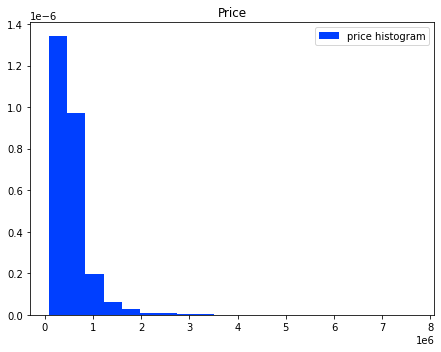

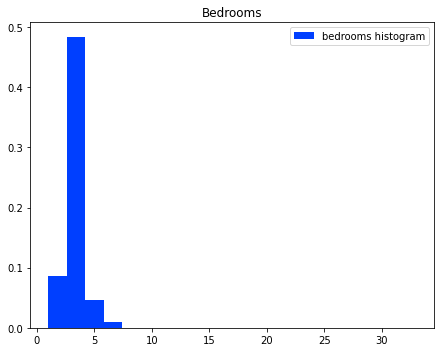

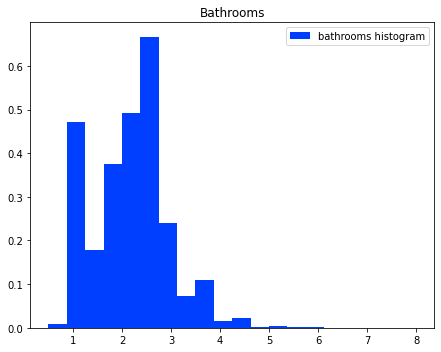

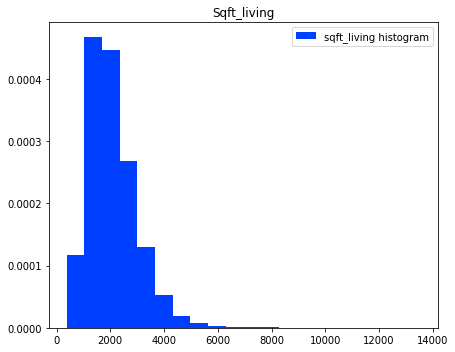

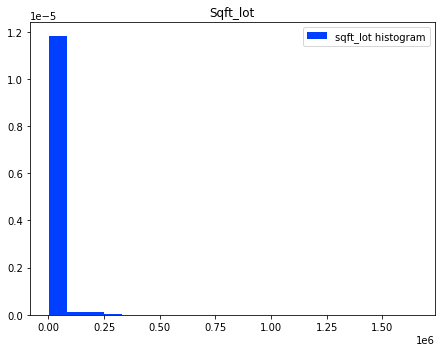

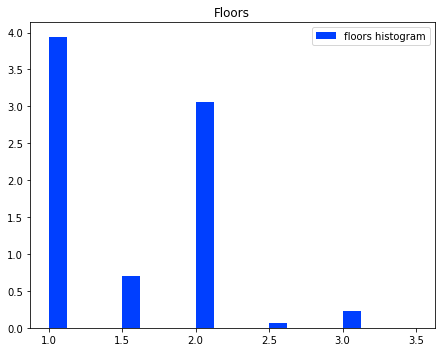

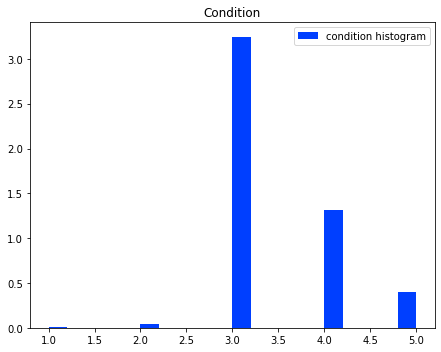

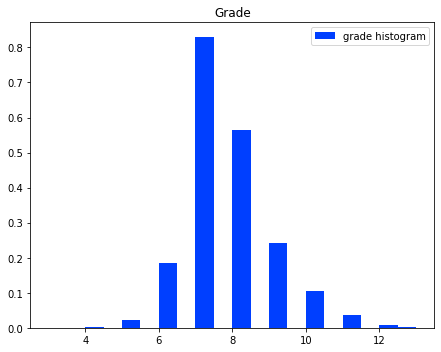

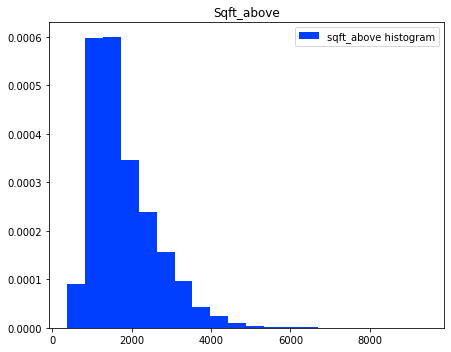

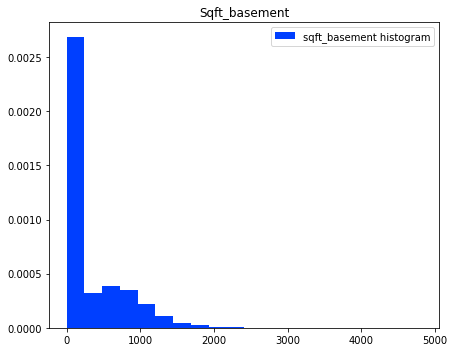

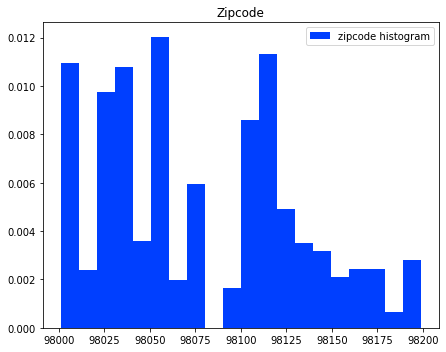

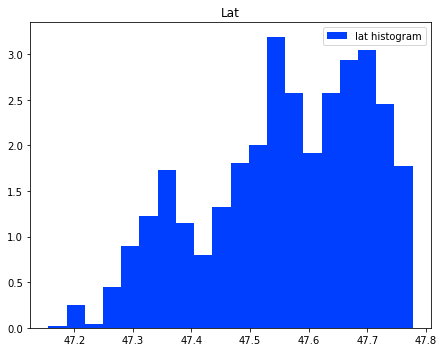

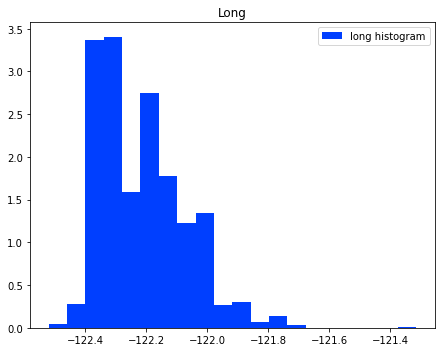

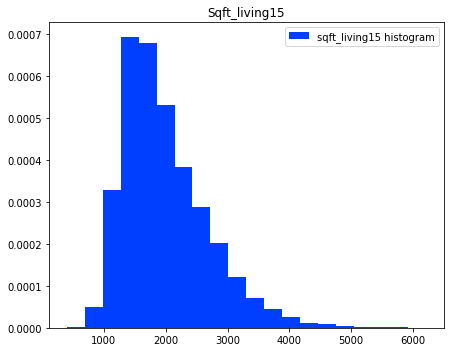

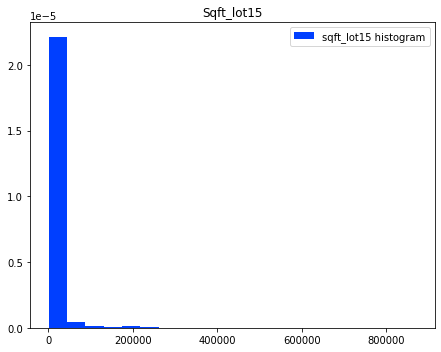

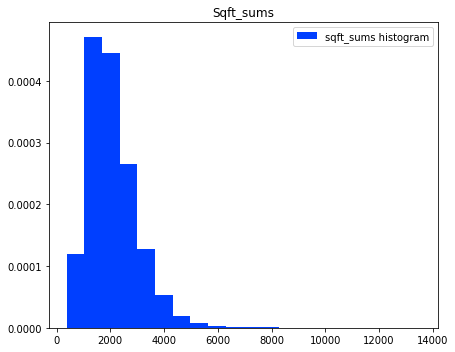

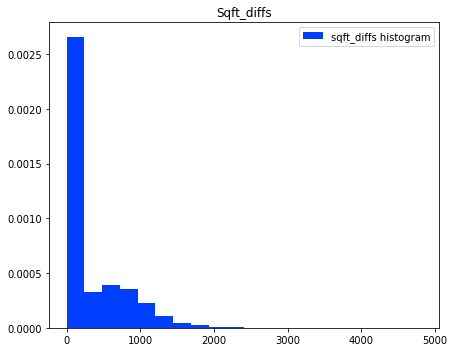

In [85]:
# hist plot
sub_hists(df)

Although sqft_living15 didn't have as much linearity with price as other candidates, it appears to have the most normal distribution out of all of them.

### KDEs

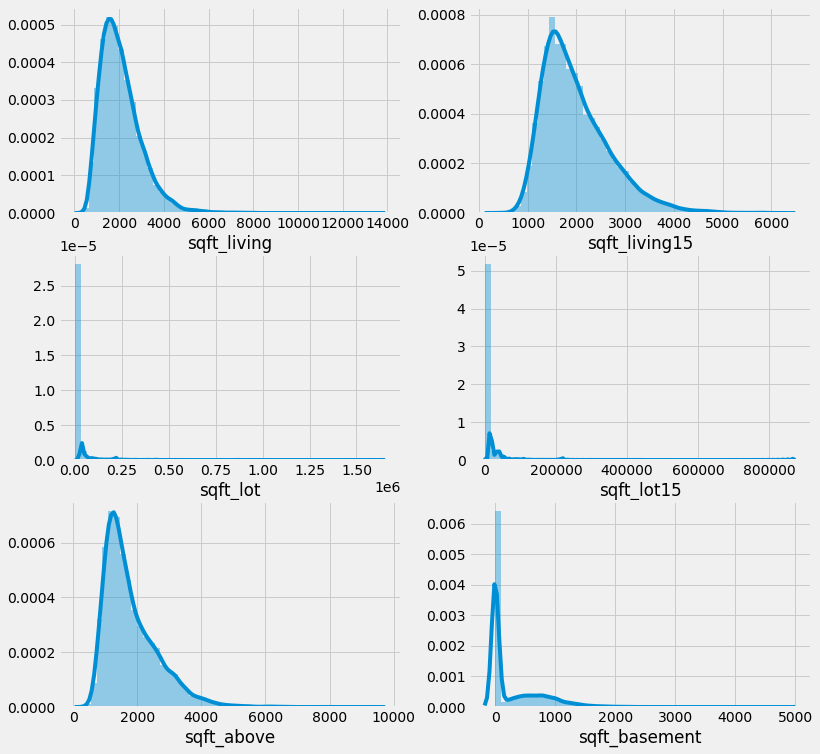

In [86]:
# Kernel Density Estimates (distplots) for square-footage variables
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
sns.distplot(df['sqft_living'], ax=ax[0][0])
sns.distplot(df['sqft_living15'], ax=ax[0][1])
sns.distplot(df['sqft_lot'], ax=ax[1][0])
sns.distplot(df['sqft_lot15'], ax=ax[1][1])
sns.distplot(df['sqft_above'], ax=ax[2][0])
sns.distplot(df['sqft_basement'], ax=ax[2][1])

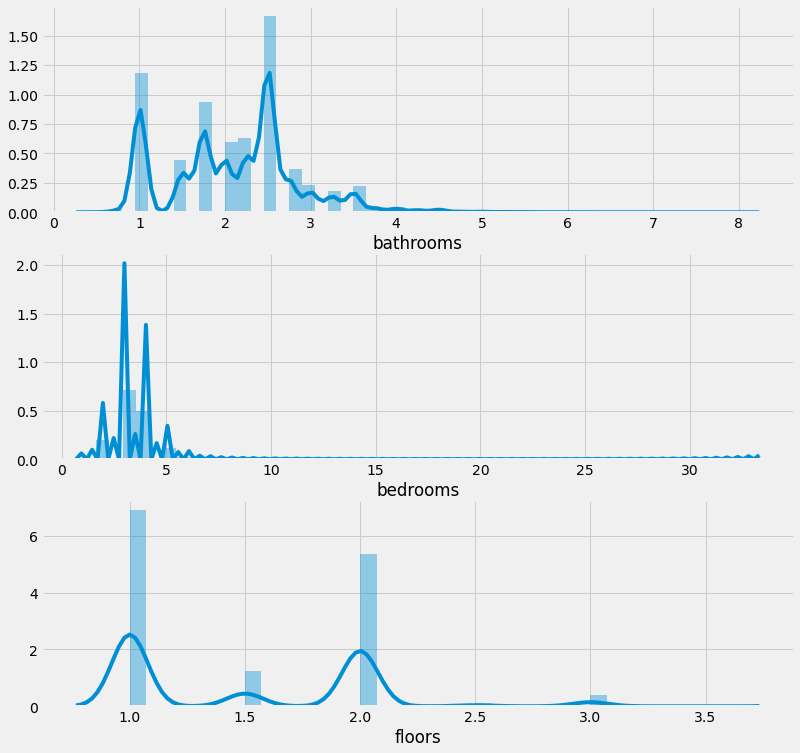

In [87]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12,12))
sns.distplot(df['bathrooms'], ax=ax[0])
sns.distplot(df['bedrooms'], ax=ax[1])
sns.distplot(df['floors'], ax=ax[2])

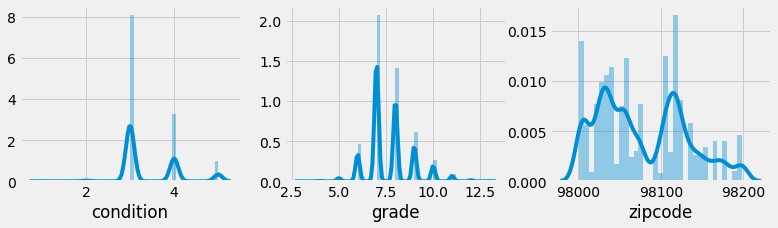

In [88]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
sns.distplot(df['condition'], ax=ax[0])
sns.distplot(df['grade'], ax=ax[1])
sns.distplot(df['zipcode'], ax=ax[2]) # look at actual zipcode value dist instead of category

> Diminishing returns for condition (highest scores = min 3 out of 5) and grade (score of 7 out of 13)
Zip Codes are all over the map...literally.

### Geographic

**QUESTION: Does geography (location) have any relationship with the values of each categorical variable?**

In [89]:
cats

['grade', 'condition', 'bathrooms', 'bedrooms', 'floors']

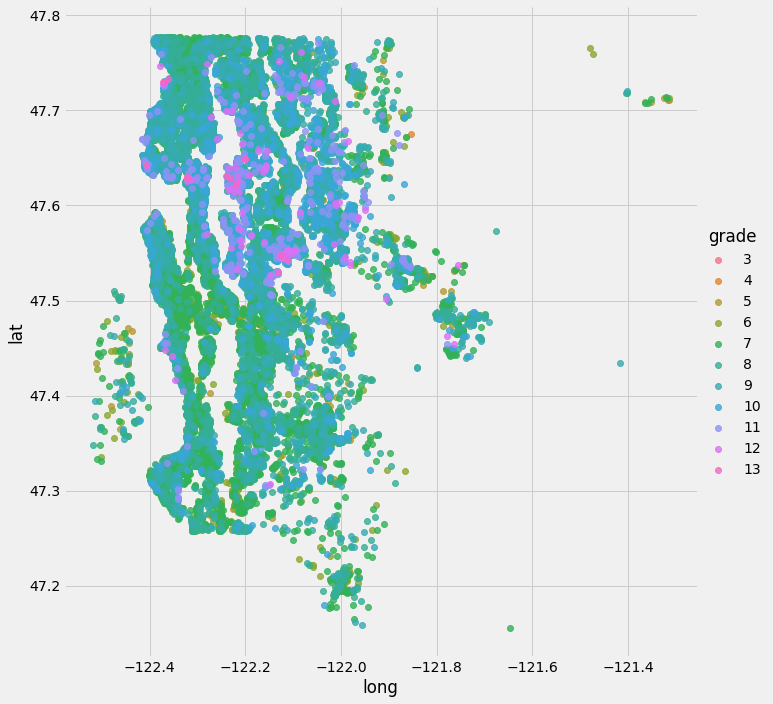

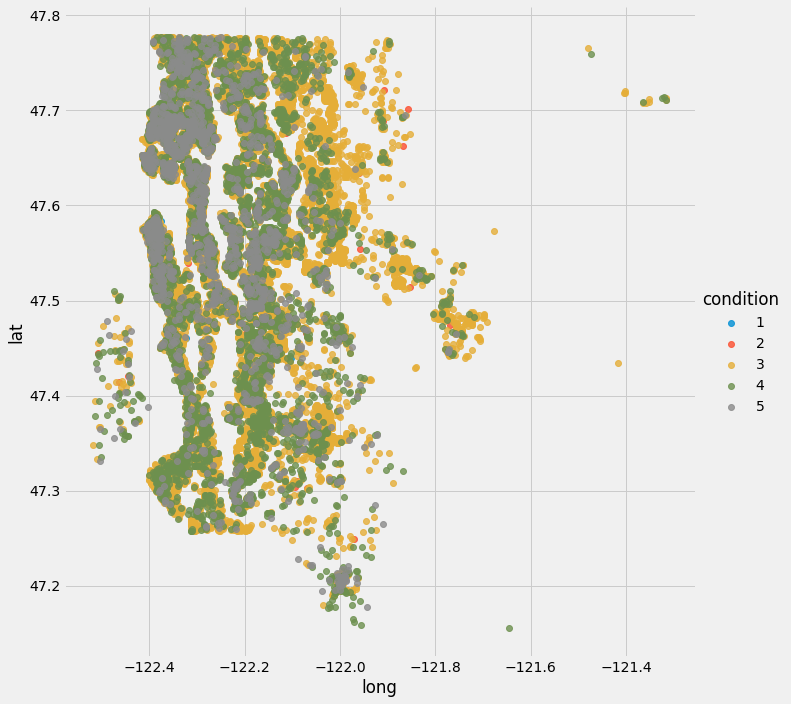

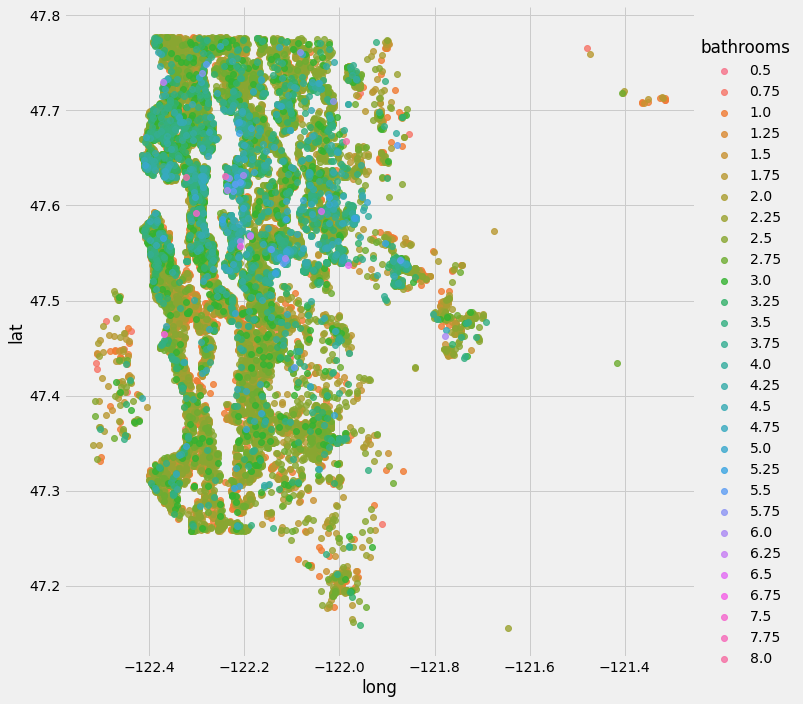

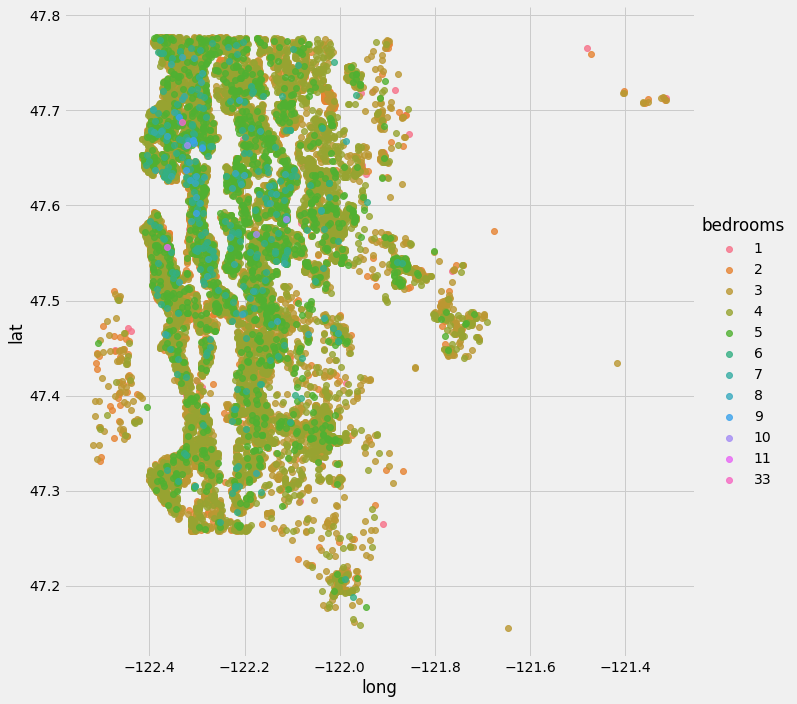

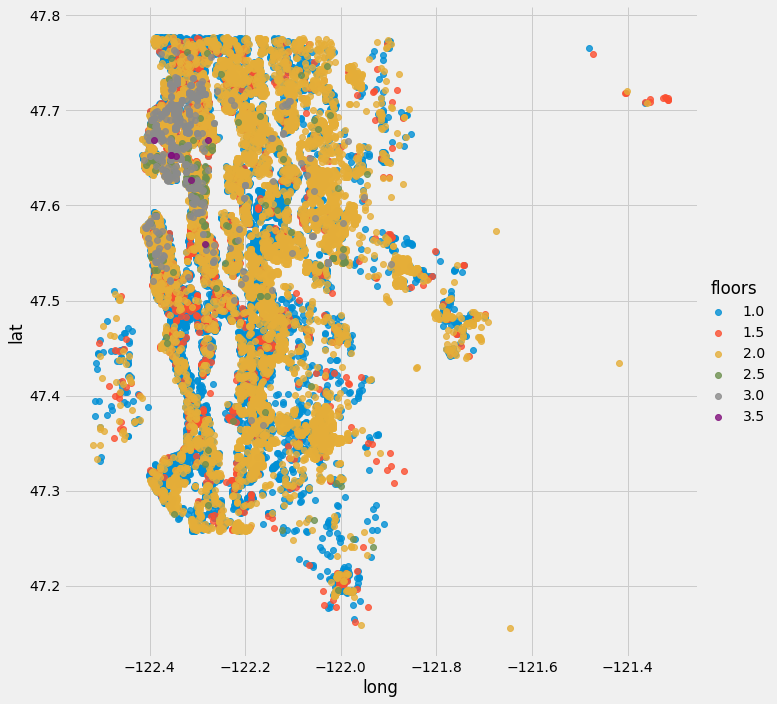

In [90]:
# lmplot geographic distribution by iterating over list of cat feats
for col in cats:
    sns.lmplot(data=df, x="long", y="lat", fit_reg=False, hue=col, height=10)
plt.show()

> The highest graded properties appear to be most dense in the upper left (NW) quadrant. Since we already know that grade has a strong correlation with price, we can posit more confidently that grade, location, and price are strongly related.

> Homes with highest number of floors tend to be located in the NW as well. If we were to look at an actual map, we'd see this is Seattle. 

In [91]:
bins

['is_wf', 'is_ren', 'viewed', 'basement', 'yb_cat', 'zip_cat', 'is_dupe']

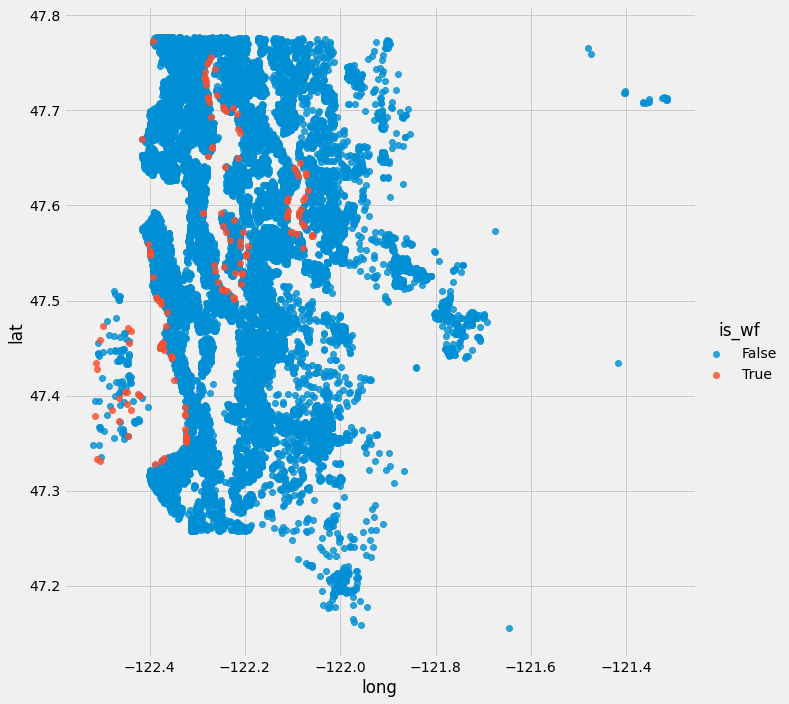

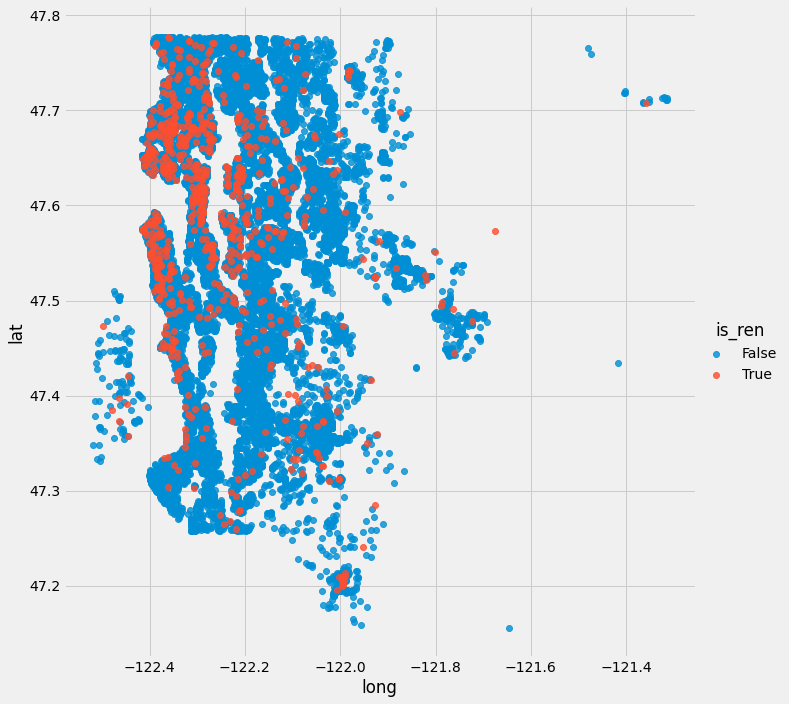

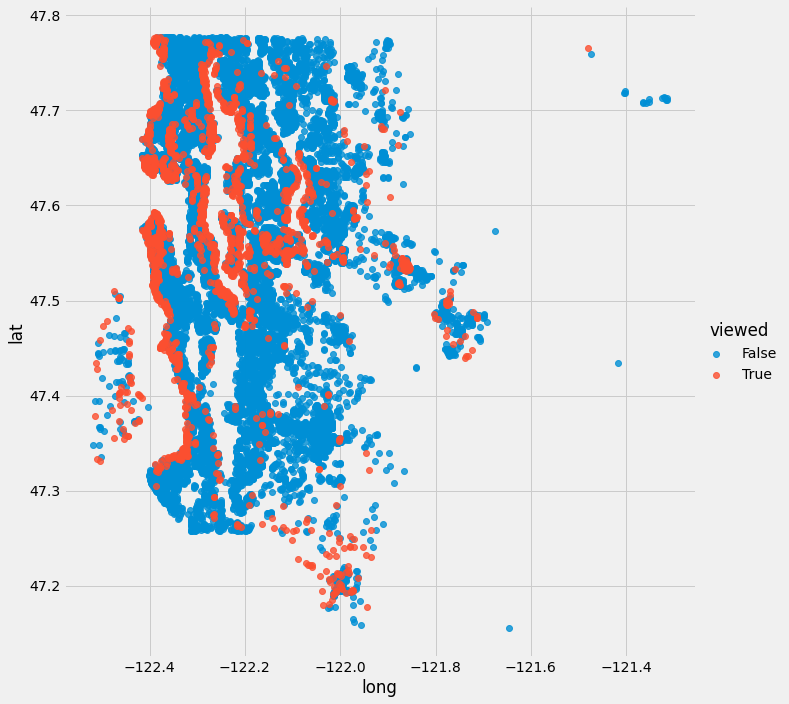

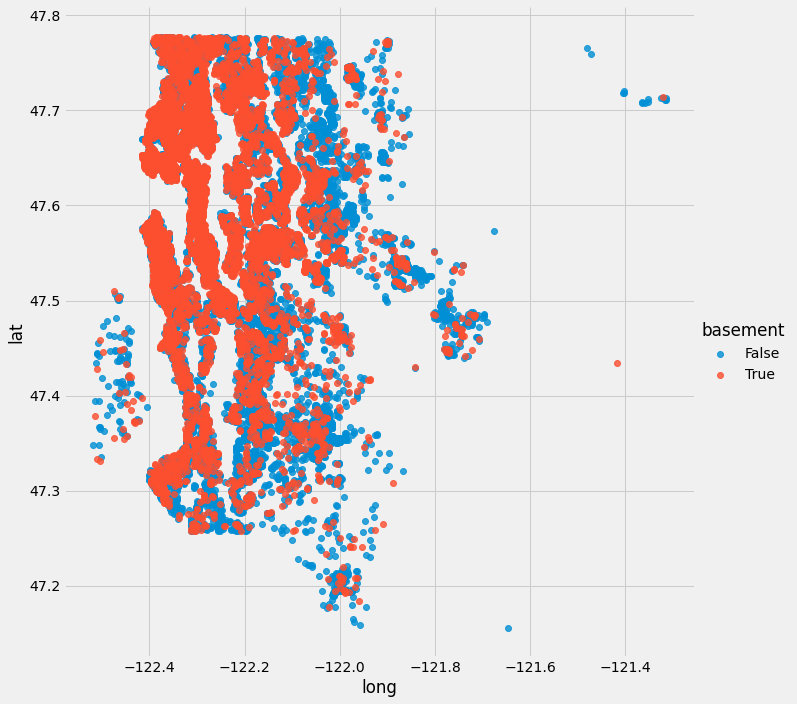

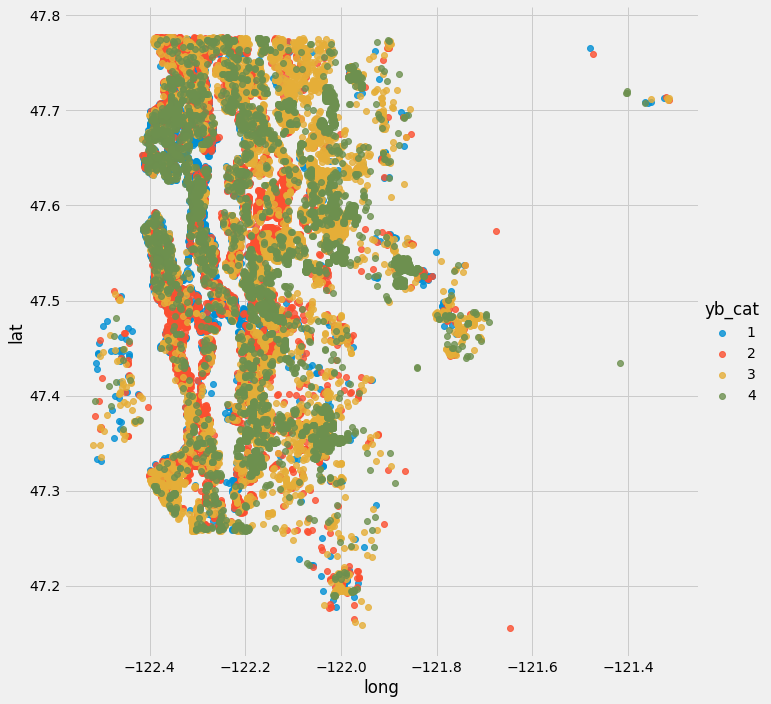

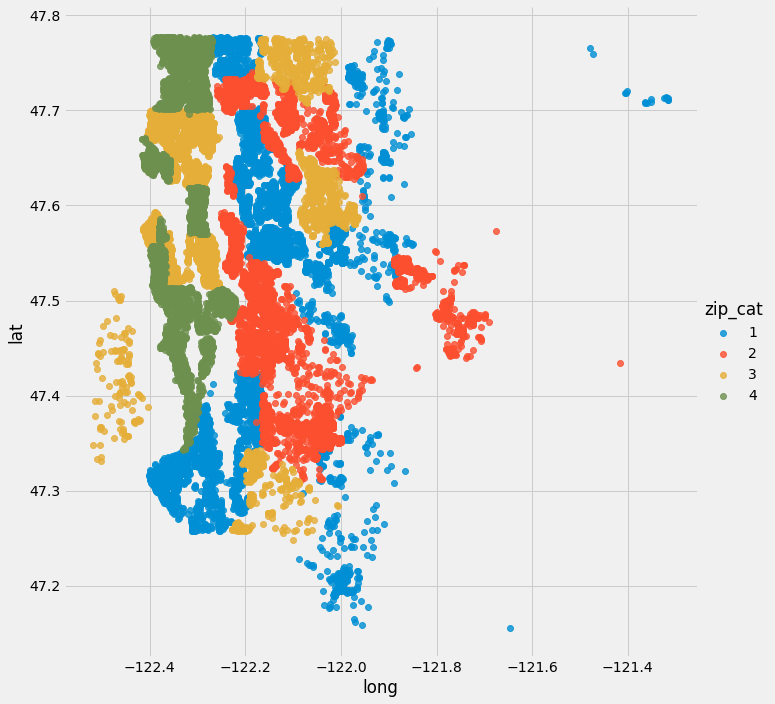

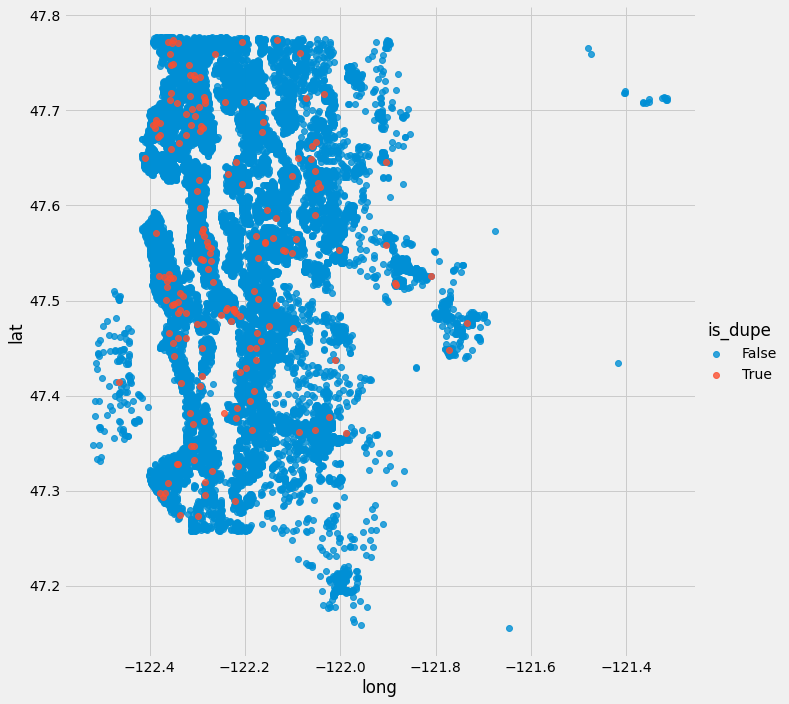

In [92]:
# run binned features through lmplot as a forloop to plot geographic distribution visual
for col in bins:
    sns.lmplot(data=df, x="long", y="lat", fit_reg=False, hue=col, height=10)
plt.show()

> Some obvious but also some interesting things to observe in the above lmplots:

* waterfront properties do indeed show up as being on the water. Unfortunately as we saw earlier, this doesn't seem to correlate much with price. This is odd (at least to me) because I'd expect those homes to be more expensive. If this were Los Angeles (where I live) that's a well-known fact...
    
* 'is_dupe' (which represents properties that sold twice in the 2 year period of this dataset) tells us pretty much nothing about anything. They look evenly distributed geographically - we can eliminate this from the model. 
    
* Probably the most surprising observation is 'viewed'. They almost all line up with the coastline, or very close to the water. This may not mean anything but it is worth noting.
    
* Lastly, is_renovated is pretty densely clumped up in the northwest quadrant (again, Seattle). We can assume therefore that a lot of renovations are taking place in the city. Not entirely useful but worth mentioning neverthless.

### Box Plots

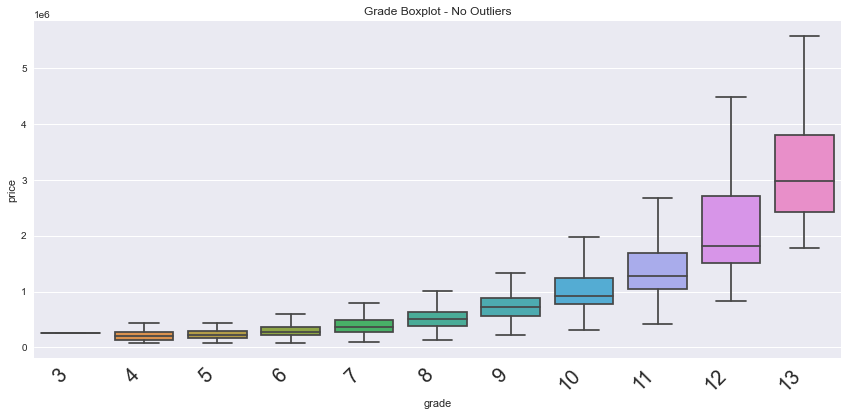

In [93]:
x = df['grade']
y = df['price']

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) # outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Grade Boxplot - No Outliers'
ax.set_title(title.title())
ax.set_xlabel('grade')
ax.set_ylabel('price')
fig.tight_layout()

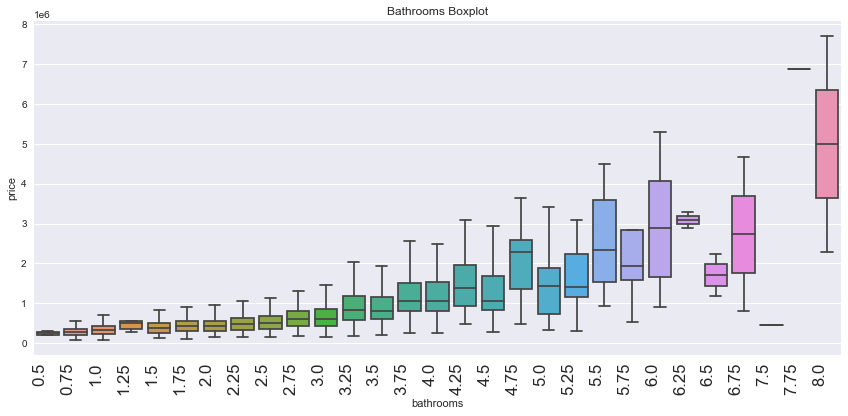

In [94]:
x = df['bathrooms']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) # outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bathrooms Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bathrooms')
ax.set_ylabel('price')
fig.tight_layout()

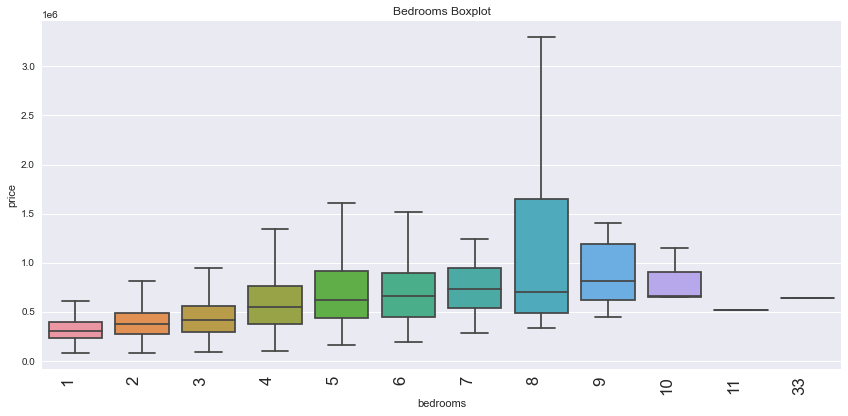

In [95]:
x = df['bedrooms']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bedrooms Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bedrooms')
ax.set_ylabel('price')
fig.tight_layout()

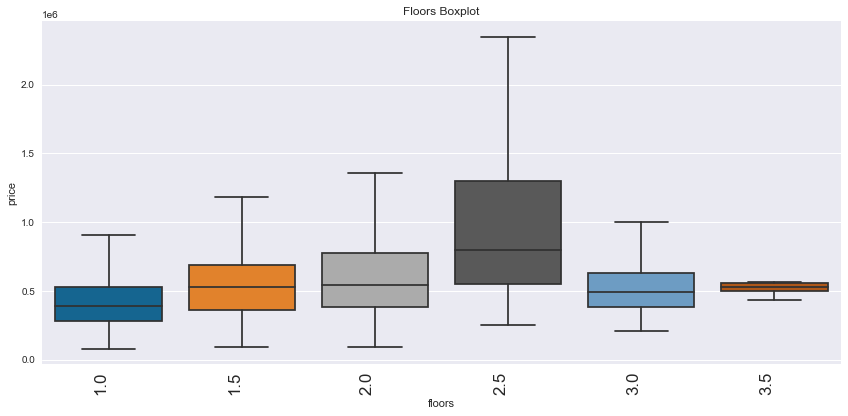

In [96]:
x = df['floors']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Floors Boxplot'
ax.set_title(title.title())
ax.set_xlabel('floors')
ax.set_ylabel('price')
fig.tight_layout()

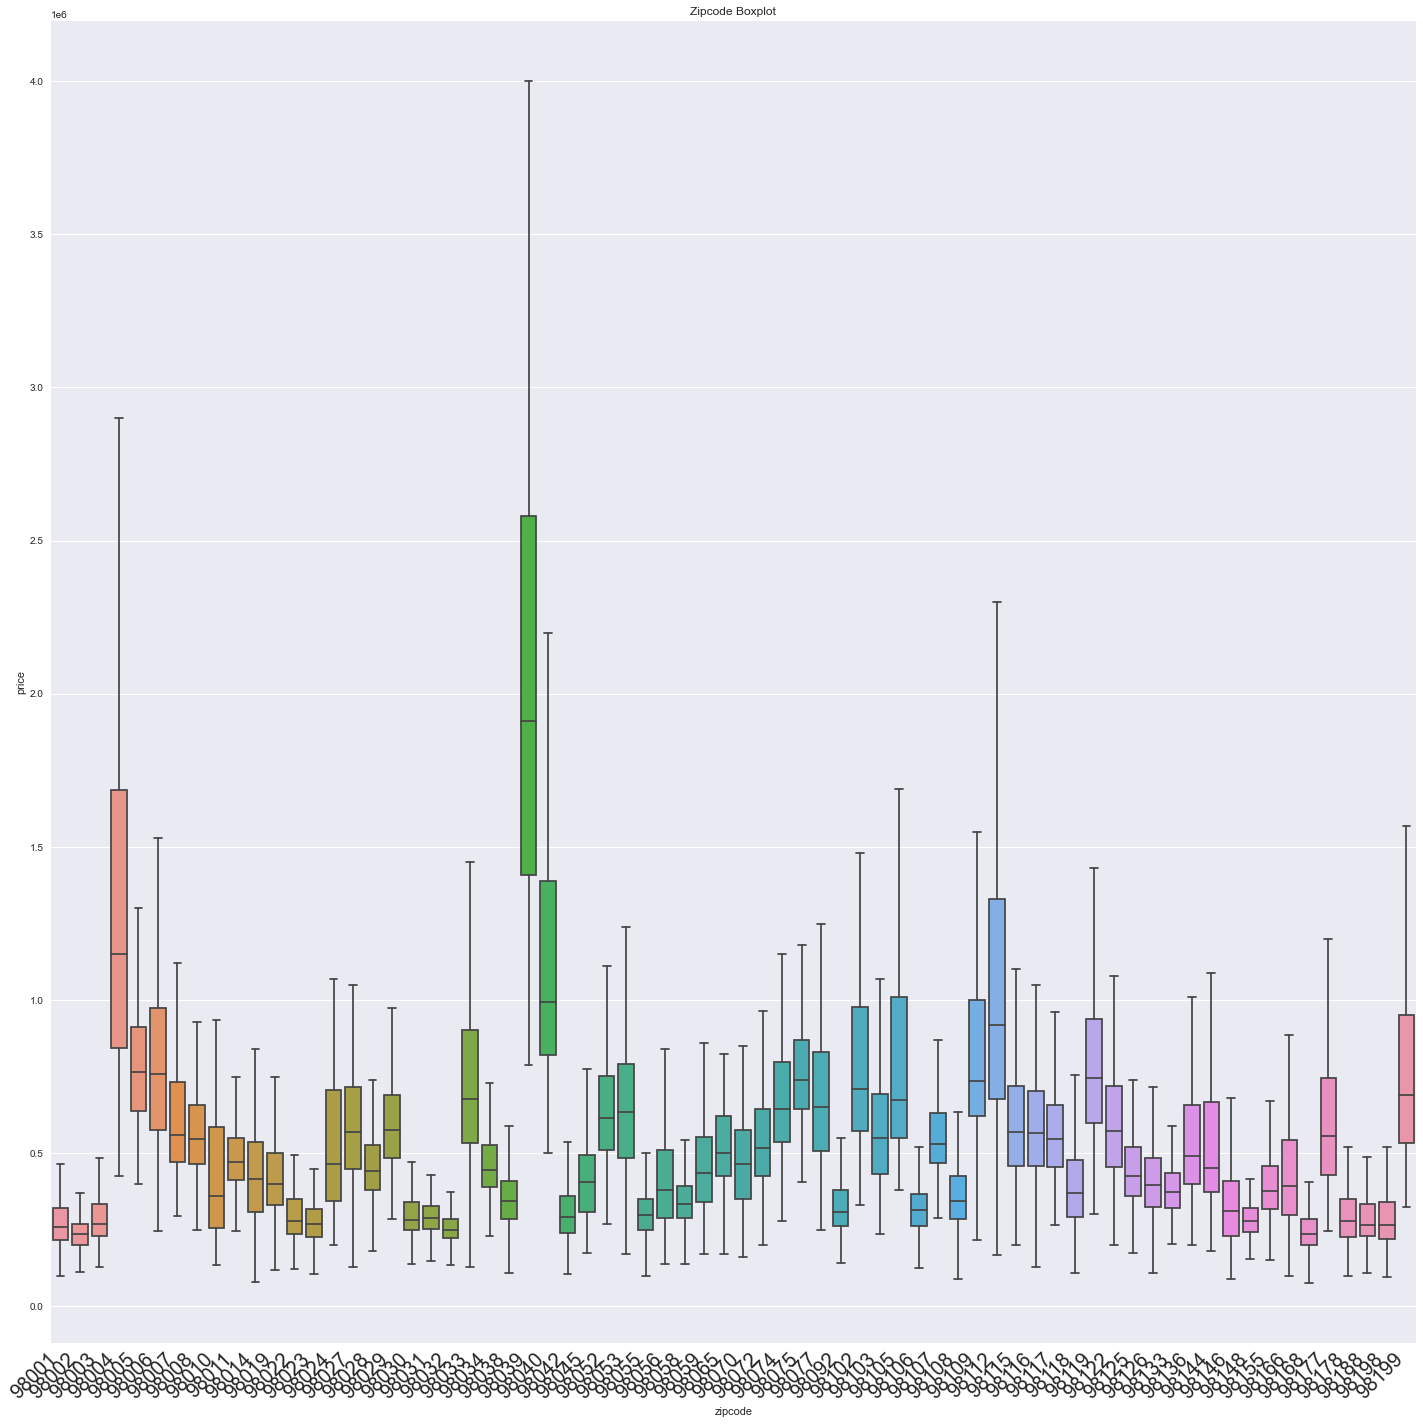

In [97]:
x = df['zipcode']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(20,20))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed

# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='zipcode boxplot'
ax.set_title(title.title())
ax.set_xlabel('zipcode')
ax.set_ylabel('price')
fig.tight_layout()

Certain zipcodes certainly contain higher home prices (mean and median) than others. This is definitely worth exploring further.

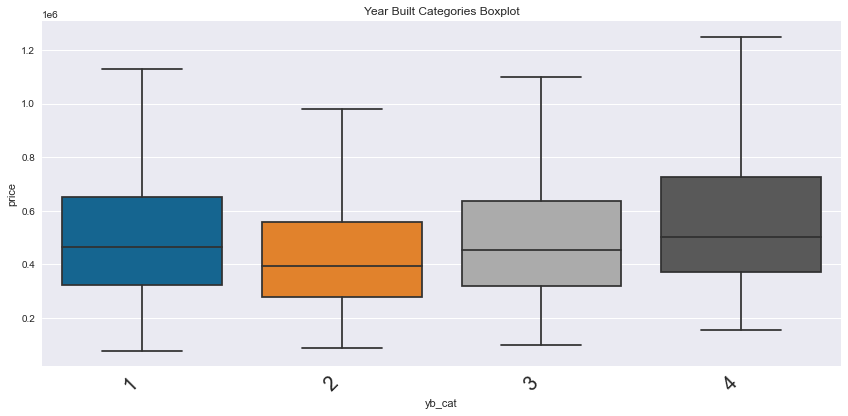

In [98]:
x = df['yb_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Year Built Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('yb_cat')
ax.set_ylabel('price')
fig.tight_layout()

To a certain degree, there is some linearity in year built, with newer homes (category4) falling within higher price ranges than older homes.

# MODEL:

Let's run the first model using features that have the highest correlation with price. (Min threshold > 0.5)

In [99]:
# BINNED VARS
corr_dict(df, bins, 'price') # none are over 0.5

{'is_wf': 0.26491453896199607,
 'is_ren': 0.11797451976936693,
 'viewed': 0.35548335378987883,
 'basement': 0.1783025402622094,
 'yb_cat': 0.0848440693678135,
 'zip_cat': -0.028890984583986763,
 'is_dupe': -0.013145274112223857}

In [100]:
# GEOGRAPHIC VARS
corr_dict(df, geo, 'price') # none are over 0.5

{'lat': 0.30643893771248304,
 'long': 0.019825644946585817,
 'zipcode': -0.0511690561394496}

In [101]:
# CATEGORICAL VARS
corr_dict(df, cats, 'price') # grade and bathrooms are over 0.5

{'grade': 0.666834956438976,
 'condition': 0.03421927419820455,
 'bathrooms': 0.5252152971165561,
 'bedrooms': 0.3096400152273569,
 'floors': 0.254971632871279}

In [102]:
# NUMERIC VARS
corr_dict(df, nums, 'price') #sqft_living, sqft_above, sqft_living15 are over 0.5

{'sqft_living': 0.7012948591175873,
 'sqft_above': 0.6044238993986455,
 'sqft_basement': 0.3212640164141516,
 'sqft_living15': 0.5837916994556079,
 'sqft_lot': 0.08878895326280659,
 'sqft_lot15': 0.08204522248404936}

NOTES: 
> The coefficients above are based on the raw values. It's possible that some of the variables will produce a higher correlation with price after scaling / transformation. We'll test this out in the second model iteration.

> We also need to take covariance/multicollinearity into consideration. As we saw when we created the multiplot heatmap (as well as scatterplots), the sqft variables have covariance. To make things more difficult, they're also collinear with grade and bathrooms. This could cause our model to overfit.

## Model 1

In [103]:
# highest corr coefs with price - initial model using raw values
pred1 = ['grade', 'sqft_living', 'bathrooms']

In [104]:
corr_dict(df, pred1, 'price')

{'grade': 0.666834956438976,
 'sqft_living': 0.7012948591175873,
 'bathrooms': 0.5252152971165561}

In [105]:
f1 = '+'.join(pred1)
f1

'grade+sqft_living+bathrooms'

In [106]:
f ='price~'+f1
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     8251.
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:04   Log-Likelihood:            -2.9666e+05
No. Observations:               21420   AIC:                         5.933e+05
Df Residuals:                   21416   BIC:                         5.934e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       -6e+05   1.34e+04    -44.765      0.000   -6.26e+05   -5.74e+05
grade        1.044e+05   2307.935     45.215      0.000    9.98e+04    1.09e+05
sqft_living   203.2884      3.354     60.617      0.000     196.715     209.862
bathrooms   -3.834e+04   3475.069    -11.033      0.000   -4.52e+04   -3.15e+04
==============================================================================
Omnibus:                    16794.800   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1000555.673
Skew:                           3.293   Prob(JB):                         0.00
Kurtosis:                      35.828   Cond. No.                     1.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> P-values look good, but the R-squared (0.536) could be much higher. 

> Skew and Kurtosis are not bad (Skew:	3.293, Kurtosis:	35.828)

> Let's do a second iteration after one-hot-encoding condition and run OLS again with zipcode included and the condition dummies.

In [107]:
# save key regression values in a dict for making quick comparisons between models
reg_mods = dict()
reg_mods['model1'] = {'vars':f1,'r2':0.536, 's': 3.293, 'k': 35.828}

reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828}}

## Model 2

### One-Hot Encoding

* Create Dummies for Condition

In [108]:
# apply one-hot encoding to condition
df2 = pd.get_dummies(df, columns=['condition'], drop_first=True)
df2.head()

price  bedrooms  bathrooms  ...  condition_3  condition_4  condition_5
0  221900.0         3       1.00  ...            1            0            0
1  538000.0         3       2.25  ...            1            0            0
2  180000.0         2       1.00  ...            1            0            0
3  604000.0         4       3.00  ...            0            0            1
4  510000.0         3       2.00  ...            1            0            0

[5 rows x 27 columns]

In [109]:
df2.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_wf', 'is_ren', 'viewed', 'basement',
       'yb_cat', 'zip_cat', 'is_dupe', 'sqft_sums', 'sqft_diffs',
       'condition_2', 'condition_3', 'condition_4', 'condition_5'],
      dtype='object')

In [110]:
# iterate through list of dummy cols to plot distributions where val > 0

# create list of dummy cols
cols = ['condition_2', 'condition_3', 'condition_4']

# create empty dict
groups={}

# iterate over dummy cols and grouby into dict for vals > 0 
for col in cols:
    groups[col]= df2.groupby(col)[col,'price'].get_group(1.0)

# check vals
groups.keys()
groups['condition_2']

condition_2     price
38               1  240000.0
242              1  455000.0
328              1  186375.0
465              1   80000.0
702              1  480000.0
...            ...       ...
19284            1  174900.0
19348            1  290000.0
19433            1  450000.0
19496            1  246500.0
19605            1  235000.0

[162 rows x 2 columns]

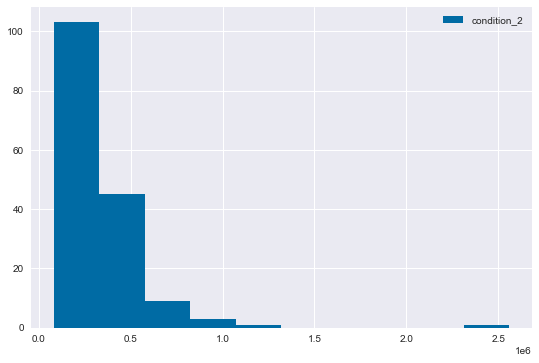

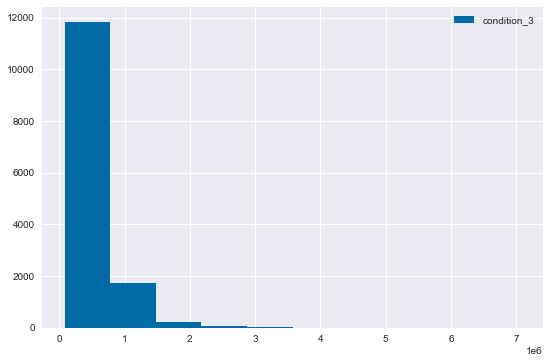

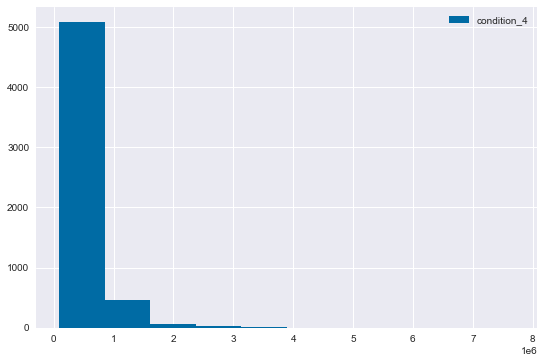

In [111]:
# show diffs between subcats of condition using histograms
for k, v in groups.items():
    plt.figure()
    plt.hist(v['price'], label=k)
    plt.legend()

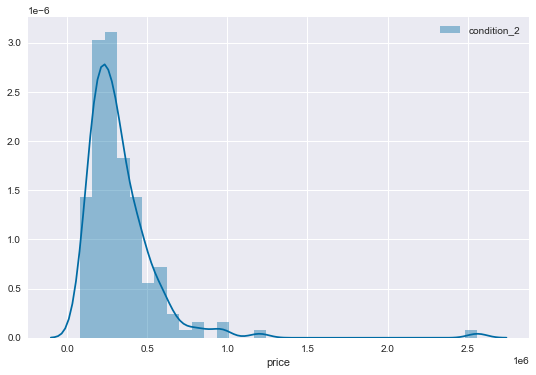

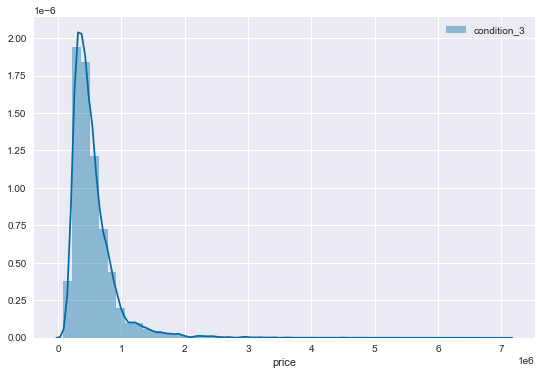

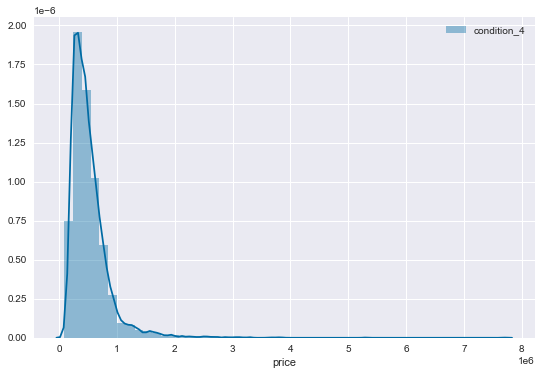

In [112]:
# As we saw before, there are diminishing returns as far as condition goes...
# visualize another way with distplots
for k, v in groups.items():
    plt.figure()
    sns.distplot(v['price'], label=k)
    plt.legend()

> NOTE condition is skewed by tails/outliers)

In [113]:
# use list comp to grab condition dummies
c_bins = [col for col in df2.columns if 'condition' in col]
c_bins

['condition_2', 'condition_3', 'condition_4', 'condition_5']

In [114]:
pred2 = ['C(zipcode)', 'grade', 'sqft_living', 'sqft_living15']

In [115]:
pred2.extend(c_bins)

In [116]:
pred2

['C(zipcode)',
 'grade',
 'sqft_living',
 'sqft_living15',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5']

In [117]:
f2 = '+'.join(pred2)
f2

'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5'

In [118]:
f ='price~'+f2
f

'price~C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5'

In [119]:
model = smf.ols(formula=f, data=df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     842.7
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:11   Log-Likelihood:            -2.9003e+05
No. Observations:               21420   AIC:                         5.802e+05
Df Residuals:                   21343   BIC:                         5.808e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.742e+05   3.73e+04    -15.415      0.000   -6.47e+05   -5.01e+05
C(zipcode)[T.98002]  3.993e+04   1.64e+04      2.438      0.015    7828.078     7.2e+04
C(zipcode)[T.98003] -8927.8223   1.48e+04     -0.605      0.545   -3.78e+04       2e+04
C(zipcode)[T.98004]  7.669e+05   1.44e+04     53.327      0.000    7.39e+05    7.95e+05
C(zipcode)[T.98005]  2.756e+05   1.73e+04     15.892      0.000    2.42e+05     3.1e+05
C(zipcode)[T.98006]  2.569e+05    1.3e+04     19.702      0.000    2.31e+05    2.82e+05
C(zipcode)[T.98007]  2.235e+05   1.84e+04     12.113      0.000    1.87e+05     2.6e+05
C(zipcode)[T.98008]  2.814e+05   1.47e+04     19.175      0.000    2.53e+05     3.1e+05
C(zipcode)[T.98010]  8.078e+04   2.09e+04      3.862      0.000    3.98e+04    1.22e+05
C(zipcode)[T.98011]  1.041e+05   1.64e+04      6.331      0.000    7.19e+04    1.36e+05
C(zipcode)[T.98014]  1.316e+05   1.92e+04      6.839      0.000    9.39e+04    1.69e+05
C(zipcode)[T.98019]  8.045e+04   1.65e+04      4.862      0.000     4.8e+04    1.13e+05
C(zipcode)[T.98022]   4.08e+04   1.55e+04      2.629      0.009    1.04e+04    7.12e+04
C(zipcode)[T.98023] -3.604e+04   1.28e+04     -2.815      0.005   -6.11e+04   -1.09e+04
C(zipcode)[T.98024]  1.935e+05   2.29e+04      8.450      0.000    1.49e+05    2.38e+05
C(zipcode)[T.98027]  1.462e+05   1.34e+04     10.935      0.000     1.2e+05    1.72e+05
C(zipcode)[T.98028]  1.129e+05   1.47e+04      7.697      0.000    8.42e+04    1.42e+05
C(zipcode)[T.98029]  1.872e+05   1.42e+04     13.143      0.000    1.59e+05    2.15e+05
C(zipcode)[T.98030] -5017.7418   1.51e+04     -0.332      0.740   -3.47e+04    2.46e+04
C(zipcode)[T.98031]   821.4336   1.48e+04      0.055      0.956   -2.82e+04    2.99e+04
C(zipcode)[T.98032]  5944.5034   1.93e+04      0.309      0.758   -3.18e+04    4.37e+04
C(zipcode)[T.98033]  3.675e+05   1.32e+04     27.814      0.000    3.42e+05    3.93e+05
C(zipcode)[T.98034]  2.099e+05   1.25e+04     16.742      0.000    1.85e+05    2.34e+05
C(zipcode)[T.98038]  1.699e+04   1.24e+04      1.374      0.170   -7254.764    4.12e+04
C(zipcode)[T.98039]  1.353e+06   2.82e+04     47.908      0.000     1.3e+06    1.41e+06
C(zipcode)[T.98040]   5.33e+05   1.49e+04     35.700      0.000    5.04e+05    5.62e+05
C(zipcode)[T.98042] -3933.0593   1.25e+04     -0.314      0.754   -2.85e+04    2.06e+04
C(zipcode)[T.98045]  1.115e+05   1.58e+04      7.046      0.000    8.05e+04    1.43e+05
C(zipcode)[T.98052]  2.063e+05   1.25e+04     16.531      0.000    1.82e+05    2.31e+05
C(zipcode)[T.98053]  1.896e+05   1.35e+04     14.064      0.000    1.63e+05    2.16e+05
C(zipcode)[T.98055]  5.794e+04    1.5e+04      3.862      0.000    2.85e+04    8.73e+04
C(zipcode)[T.98056]  9.847e+04   1.34e+04      7.355      0.000    7.22e+04    1.25e+05
C(z

In [120]:
# store model2 values to dict
reg_mods['model2'] = {'vars':f2, 'r2':0.750, 's': 5.170, 'k': 75.467}

reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828},
 'model2': {'vars': 'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5',
  'r2': 0.75,
  's': 5.17,
  'k': 75.467}}

> Much higher R-squared but there are some fatal issues with this model:
1. There are a handful of zipcodes with very high P-values. 
2. Condition dummies have very high p-values.
3. Skew: 5.170 (increased)
4. Kurtosis: 75.467	(almost doubled from model1)

> Let's drop condition and try running it again.

## Model 3

In [121]:
# create list of selected predictors
pred3 = ['C(zipcode)','grade', 'sqft_living']

# convert to string with + added
f3 = '+'.join(pred3)

# append target
f ='price~'+f3 

# Run model and show sumamry
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     874.7
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:11   Log-Likelihood:            -2.9028e+05
No. Observations:               21420   AIC:                         5.807e+05
Df Residuals:                   21348   BIC:                         5.813e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.465e+05   1.43e+04    -38.190      0.000   -5.75e+05   -5.18e+05
C(zipcode)[T.98002]  4.496e+04   1.65e+04      2.719      0.007    1.26e+04    7.74e+04
C(zipcode)[T.98003] -6822.5330   1.49e+04     -0.457      0.648   -3.61e+04    2.24e+04
C(zipcode)[T.98004]  7.897e+05   1.45e+04     54.481      0.000    7.61e+05    8.18e+05
C(zipcode)[T.98005]  3.065e+05   1.75e+04     17.538      0.000    2.72e+05    3.41e+05
C(zipcode)[T.98006]  2.911e+05   1.31e+04     22.254      0.000    2.65e+05    3.17e+05
C(zipcode)[T.98007]  2.408e+05   1.86e+04     12.926      0.000    2.04e+05    2.77e+05
C(zipcode)[T.98008]  2.968e+05   1.48e+04     20.029      0.000    2.68e+05    3.26e+05
C(zipcode)[T.98010]  9.059e+04   2.11e+04      4.284      0.000    4.91e+04    1.32e+05
C(zipcode)[T.98011]  1.108e+05   1.66e+04      6.669      0.000    7.82e+04    1.43e+05
C(zipcode)[T.98014]  1.266e+05   1.95e+04      6.506      0.000    8.85e+04    1.65e+05
C(zipcode)[T.98019]  7.734e+04   1.67e+04      4.626      0.000    4.46e+04     1.1e+05
C(zipcode)[T.98022]  5.591e+04   1.57e+04      3.567      0.000    2.52e+04    8.66e+04
C(zipcode)[T.98023] -2.971e+04   1.29e+04     -2.295      0.022   -5.51e+04   -4339.713
C(zipcode)[T.98024]  1.954e+05   2.32e+04      8.436      0.000     1.5e+05    2.41e+05
C(zipcode)[T.98027]  1.597e+05   1.35e+04     11.821      0.000    1.33e+05    1.86e+05
C(zipcode)[T.98028]  1.182e+05   1.48e+04      7.967      0.000    8.91e+04    1.47e+05
C(zipcode)[T.98029]  1.883e+05   1.44e+04     13.074      0.000     1.6e+05    2.17e+05
C(zipcode)[T.98030] -4392.7892   1.53e+04     -0.287      0.774   -3.44e+04    2.56e+04
C(zipcode)[T.98031]  8757.3262    1.5e+04      0.584      0.559   -2.06e+04    3.81e+04
C(zipcode)[T.98032]  1.241e+04   1.95e+04      0.638      0.524   -2.57e+04    5.06e+04
C(zipcode)[T.98033]  3.806e+05   1.34e+04     28.512      0.000    3.54e+05    4.07e+05
C(zipcode)[T.98034]  2.133e+05   1.27e+04     16.821      0.000    1.88e+05    2.38e+05
C(zipcode)[T.98038]  1.851e+04   1.25e+04      1.481      0.139   -5984.381     4.3e+04
C(zipcode)[T.98039]  1.378e+06   2.85e+04     48.288      0.000    1.32e+06    1.43e+06
C(zipcode)[T.98040]   5.73e+05    1.5e+04     38.259      0.000    5.44e+05    6.02e+05
C(zipcode)[T.98042]  6777.9856   1.27e+04      0.535      0.593    -1.8e+04    3.16e+04
C(zipcode)[T.98045]  1.059e+05    1.6e+04      6.619      0.000    7.46e+04    1.37e+05
C(zipcode)[T.98052]  2.178e+05   1.26e+04     17.280      0.000    1.93e+05    2.42e+05
C(zipcode)[T.98053]  1.927e+05   1.36e+04     14.163      0.000    1.66e+05    2.19e+05
C(zipcode)[T.98055]  5.831e+04   1.52e+04      3.843      0.000    2.86e+04    8.81e+04
C(zipcode)[T.98056]  1.142e+05   1.35e+04      8.446      0.000    8.77e+04    1.41e+05
C(z

In [122]:
reg_mods['model3'] = {'vars':f3, 'r2':0.744, 's': 4.927, 'k':69.417 }
reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828},
 'model2': {'vars': 'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5',
  'r2': 0.75,
  's': 5.17,
  'k': 75.467},
 'model3': {'vars': 'C(zipcode)+grade+sqft_living',
  'r2': 0.744,
  's': 4.927,
  'k': 69.417}}

> R-squared value slightly decreased 

> P-values look good

> Skew and Kurtosis decreased slightly (compared to Model2 at least)

### Error Terms ('grade')

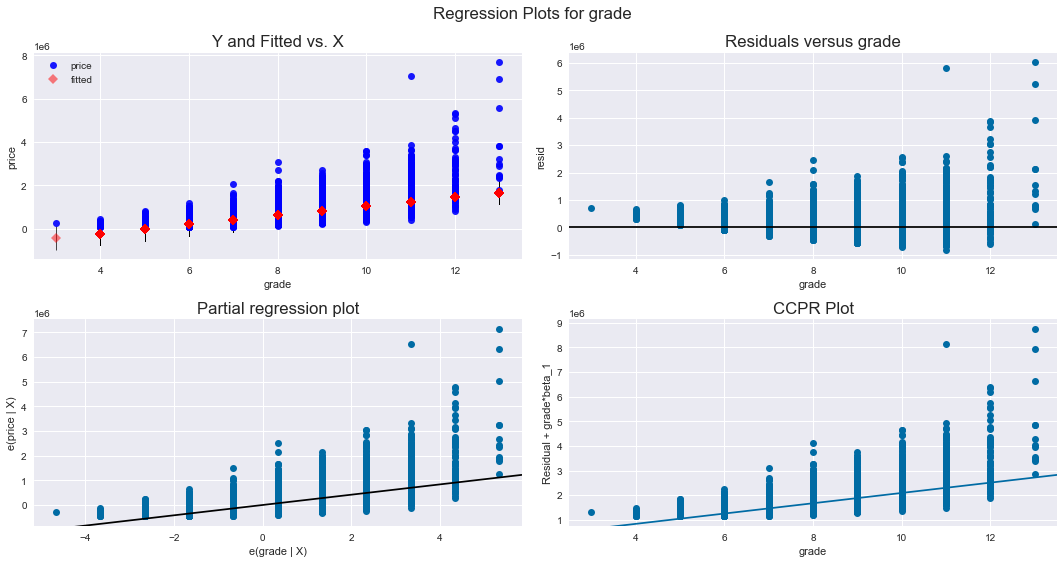

In [123]:
# Visualize Error Terms for Grade
f = 'price~grade'
model = smf.ols(formula=f, data=df).fit()
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'grade', fig=fig)
plt.show()

## Model 4

In [124]:
# checking same model with GRADE as cat.
pred4 = ['C(zipcode)', 'C(grade)', 'sqft_living']

# convert to string with + added
f4 = '+'.join(pred4)

# append target
f ='price~'+f4 

# Run model and show sumamry
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     960.1
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:14   Log-Likelihood:            -2.8854e+05
No. Observations:               21420   AIC:                         5.772e+05
Df Residuals:                   21339   BIC:                         5.779e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.245e+05   1.72e+05      0.722      0.470   -2.13e+05    4.62e+05
C(zipcode)[T.98002]  1.512e+04   1.53e+04      0.991      0.322   -1.48e+04     4.5e+04
C(zipcode)[T.98003]  2575.7351   1.38e+04      0.187      0.852   -2.44e+04    2.96e+04
C(zipcode)[T.98004]  7.673e+05   1.34e+04     57.349      0.000    7.41e+05    7.94e+05
C(zipcode)[T.98005]   3.08e+05   1.61e+04     19.095      0.000    2.76e+05     3.4e+05
C(zipcode)[T.98006]  2.688e+05   1.21e+04     22.252      0.000    2.45e+05    2.92e+05
C(zipcode)[T.98007]  2.533e+05   1.72e+04     14.742      0.000     2.2e+05    2.87e+05
C(zipcode)[T.98008]  3.092e+05   1.37e+04     22.621      0.000    2.82e+05    3.36e+05
C(zipcode)[T.98010]  7.262e+04   1.95e+04      3.721      0.000    3.44e+04    1.11e+05
C(zipcode)[T.98011]  1.298e+05   1.53e+04      8.473      0.000    9.98e+04     1.6e+05
C(zipcode)[T.98014]  1.022e+05    1.8e+04      5.685      0.000     6.7e+04    1.37e+05
C(zipcode)[T.98019]  8.799e+04   1.54e+04      5.706      0.000    5.78e+04    1.18e+05
C(zipcode)[T.98022]  4.724e+04   1.45e+04      3.263      0.001    1.89e+04    7.56e+04
C(zipcode)[T.98023] -2.411e+04   1.19e+04     -2.019      0.044   -4.75e+04    -699.359
C(zipcode)[T.98024]  1.756e+05   2.14e+04      8.216      0.000    1.34e+05    2.17e+05
C(zipcode)[T.98027]  1.618e+05   1.25e+04     12.976      0.000    1.37e+05    1.86e+05
C(zipcode)[T.98028]  1.348e+05   1.37e+04      9.853      0.000    1.08e+05    1.62e+05
C(zipcode)[T.98029]  2.091e+05   1.33e+04     15.713      0.000    1.83e+05    2.35e+05
C(zipcode)[T.98030]  2521.7309   1.41e+04      0.179      0.858   -2.51e+04    3.02e+04
C(zipcode)[T.98031]  1.681e+04   1.38e+04      1.215      0.224   -1.03e+04    4.39e+04
C(zipcode)[T.98032]  7757.5538    1.8e+04      0.432      0.666   -2.74e+04    4.29e+04
C(zipcode)[T.98033]  3.736e+05   1.23e+04     30.325      0.000    3.49e+05    3.98e+05
C(zipcode)[T.98034]  2.135e+05   1.17e+04     18.255      0.000    1.91e+05    2.36e+05
C(zipcode)[T.98038]   3.13e+04   1.15e+04      2.715      0.007    8707.828    5.39e+04
C(zipcode)[T.98039]  1.254e+06   2.64e+04     47.461      0.000     1.2e+06    1.31e+06
C(zipcode)[T.98040]   5.62e+05   1.38e+04     40.625      0.000    5.35e+05    5.89e+05
C(zipcode)[T.98042]  1.102e+04   1.17e+04      0.944      0.345   -1.19e+04    3.39e+04
C(zipcode)[T.98045]  1.055e+05   1.48e+04      7.145      0.000    7.65e+04    1.34e+05
C(zipcode)[T.98052]  2.363e+05   1.16e+04     20.305      0.000    2.13e+05    2.59e+05
C(zipcode)[T.98053]  2.027e+05   1.26e+04     16.150      0.000    1.78e+05    2.27e+05
C(zipcode)[T.98055]  4.796e+04    1.4e+04      3.425      0.001    2.05e+04    7.54e+04
C(zipcode)[T.98056]  1.059e+05   1.25e+04      8.485      0.000    8.15e+04     1.3e+05
C(z

In [125]:
reg_mods['model4'] = {'vars': f4, 'r2':0.783, 's':4.032,'k':55.222 }
reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828},
 'model2': {'vars': 'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5',
  'r2': 0.75,
  's': 5.17,
  'k': 75.467},
 'model3': {'vars': 'C(zipcode)+grade+sqft_living',
  'r2': 0.744,
  's': 4.927,
  'k': 69.417},
 'model4': {'vars': 'C(zipcode)+C(grade)+sqft_living',
  'r2': 0.783,
  's': 4.032,
  'k': 55.222}}

> R-squared value increased from 0.75 to 0.78 - better.  

> P-values for Grade as a categorical are horrible except for scores of 11, 12, and 13. This could mean we recommend Grade as a factor still, with the requirement that the home score above 10 in order to have an impact on price. 

> Kurtosis and Skew both decreased to levels lower than models 2 and 3. However, the model would most likely benefit further from scaling/normalization. 

### QQ Plots
Investigate high p-values

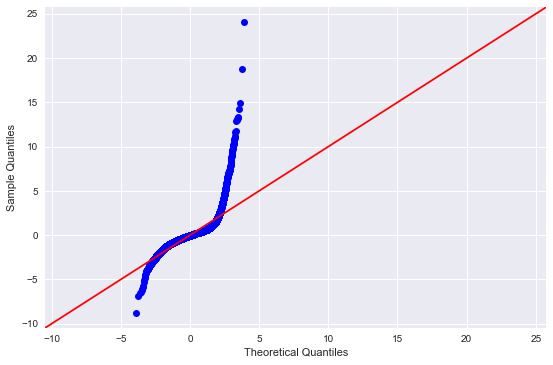

In [126]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

> This is not what we want to see...Let's take a closer look at the outliers and find out if removing them helps at all. If not, we may need to drop Grade from the model.

## Model 5

### Outliers

**QUESTION: Does removing outliers improve the distribution?**

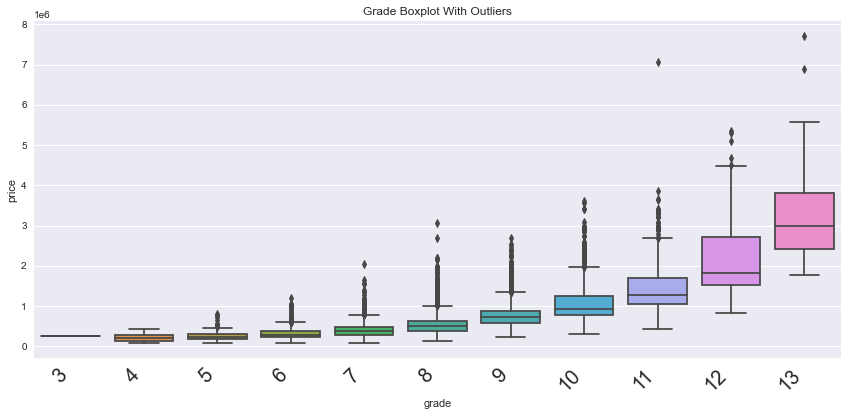

In [127]:
# Visualize outliers with boxplot for grade
x = 'grade'
y = 'price'

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))

# iterate over categorical vars to build boxplots of price distributions

sns.boxplot(data=df, x=x, y=y, ax=ax)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Grade Boxplot with Outliers'
ax.set_title(title.title())
ax.set_xlabel('grade')
ax.set_ylabel('price')
fig.tight_layout()

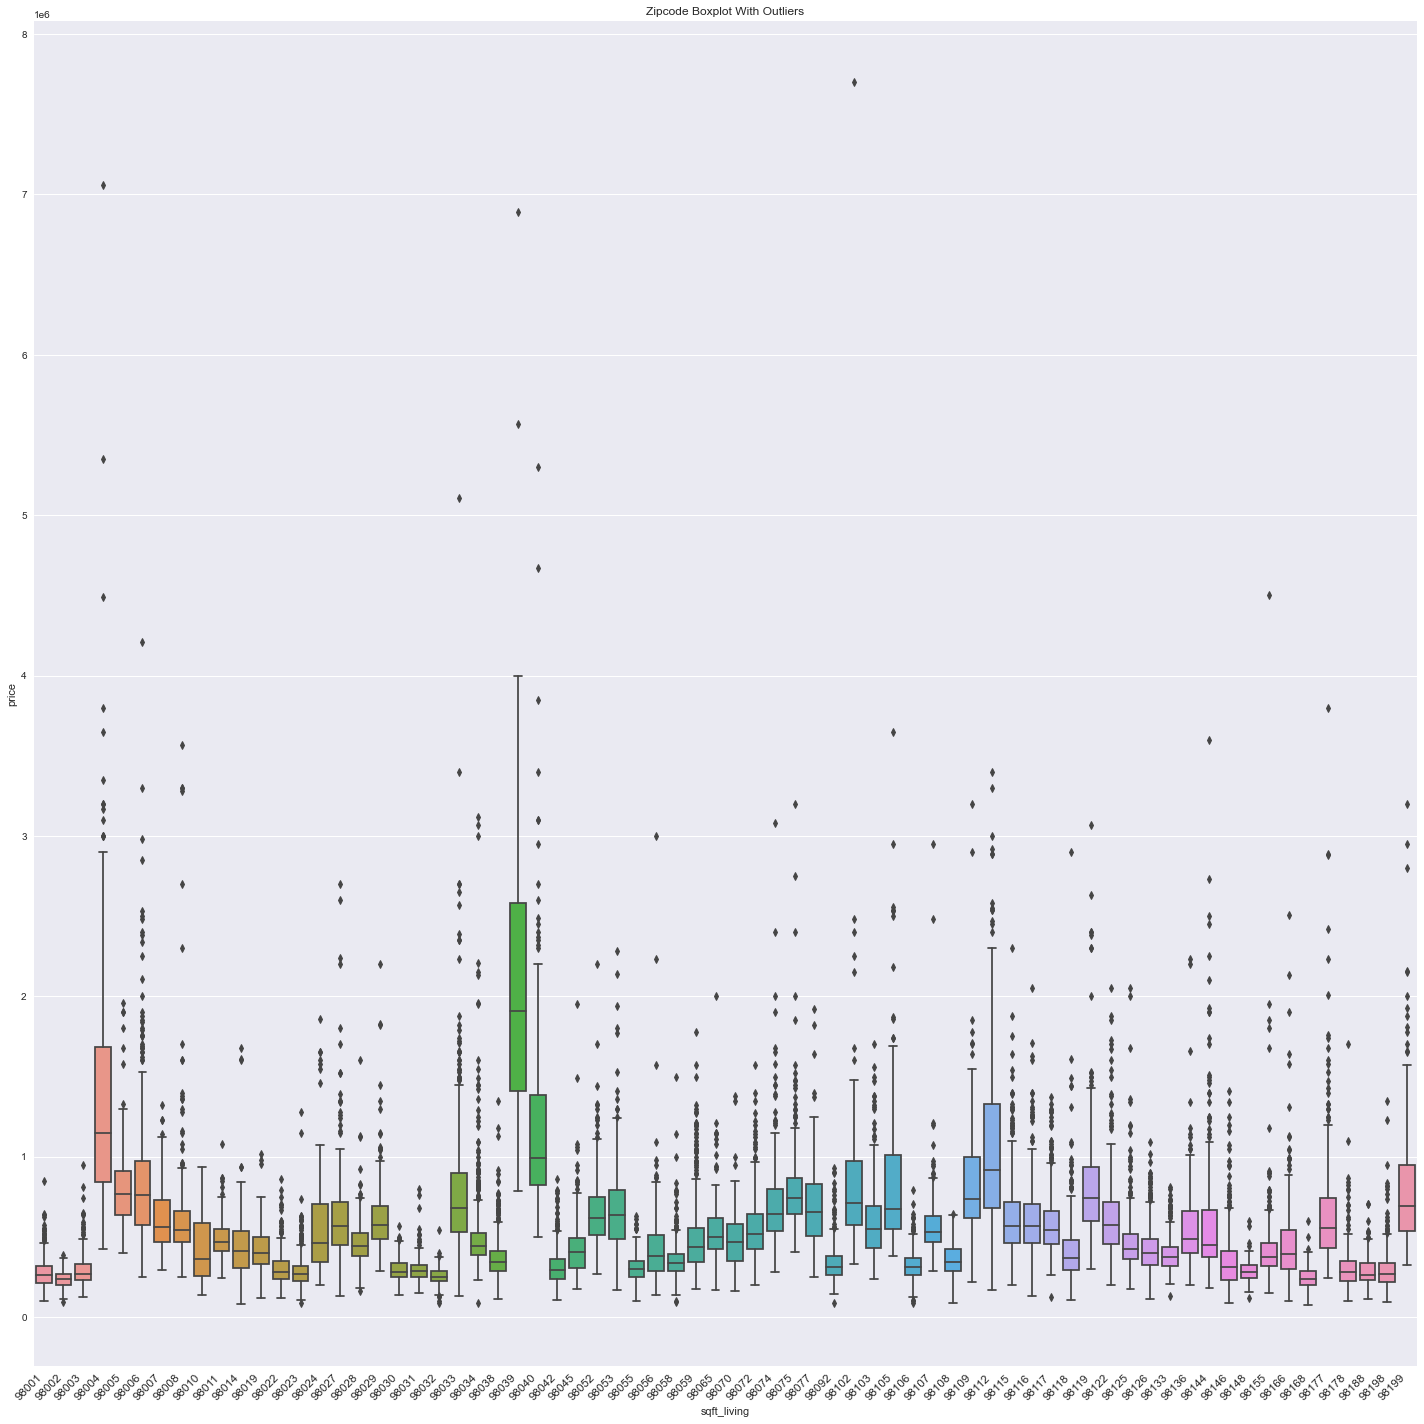

In [128]:
# visualize outliers with boxplot for zipcode
x = 'zipcode'
y = 'price'

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(20,20))

# iterate over categorical vars to build boxplots of price distributions

sns.boxplot(data=df, x=x, y=y, ax=ax)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='small',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Zipcode Boxplot with Outliers'
ax.set_title(title.title())
ax.set_xlabel('sqft_living')
ax.set_ylabel('price')
fig.tight_layout()

> NOTE: If the assumption about zipcode (i.e. location) being a critical factor for home price is correct, we could identify from this a list of zipcodes with the highest prices of homes based on median home values -- the assumption for this being that people will pay more for a house located in a certain area than they would for a house in other parts of the county (even if that house is much bigger, has a higher grade, etc). 

In [129]:
# Detect actual number of outliers for our predictors

out_vars = ['sqft_living', 'zipcode', 'grade', 'price']

df_outs = df[out_vars]
df_outs

sqft_living  zipcode  grade     price
0             1180    98178      7  221900.0
1             2570    98125      7  538000.0
2              770    98028      6  180000.0
3             1960    98136      7  604000.0
4             1680    98074      8  510000.0
...            ...      ...    ...       ...
21592         1530    98103      8  360000.0
21593         2310    98146      8  400000.0
21594         1020    98144      7  402101.0
21595         1600    98027      8  400000.0
21596         1020    98144      7  325000.0

[21420 rows x 4 columns]

In [130]:
# Get IQR scores
Q1 = df_outs.quantile(0.25)
Q3 = df_outs.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

sqft_living      1120.0
zipcode            84.0
grade               1.0
price          320050.0
dtype: float64


In [131]:

# True indicates outliers present
outliers = (df_outs < (Q1 - 1.5 * IQR)) |(df_outs > (Q3 + 1.5 * IQR))

for col in outliers:
    print(outliers[col].value_counts(normalize=True))

False    0.973483
True     0.026517
Name: sqft_living, dtype: float64
False    1.0
Name: zipcode, dtype: float64
False    0.911811
True     0.088189
Name: grade, dtype: float64
False    0.946218
True     0.053782
Name: price, dtype: float64


> 8% of the values in grade and 5% in price are outliers.

In [132]:
# Remove outliers 
df_zero_outs = df_outs[~((df_outs < (Q1 - 1.5 * IQR)) |(df_outs > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_outs.shape, df_zero_outs.shape)

(21420, 4) (19032, 4)


In [133]:
# number of outliers removed
df_outs.shape[0] - df_zero_outs.shape[0] # 2388

2388

In [134]:
# rerun OLS with outliers removed
pred5 = ['C(zipcode)', 'C(grade)', 'sqft_living']

# convert to string with + added
f5 = '+'.join(pred5)

# append target
f ='price~'+f5 

# Run model and show sumamry
model = smf.ols(formula=f, data=df_zero_outs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     922.9
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:22   Log-Likelihood:            -2.4420e+05
No. Observations:               19032   AIC:                         4.886e+05
Df Residuals:                   18958   BIC:                         4.891e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.231e+04   5543.838      2.221      0.026    1445.035    2.32e+04
C(zipcode)[T.98002]  6351.0940   8273.604      0.768      0.443   -9865.908    2.26e+04
C(zipcode)[T.98003]  9032.9996   7434.520      1.215      0.224   -5539.322    2.36e+04
C(zipcode)[T.98004]  5.348e+05   8930.554     59.882      0.000    5.17e+05    5.52e+05
C(zipcode)[T.98005]  3.542e+05   9156.645     38.683      0.000    3.36e+05    3.72e+05
C(zipcode)[T.98006]  2.922e+05   6944.783     42.071      0.000    2.79e+05    3.06e+05
C(zipcode)[T.98007]  2.603e+05   9524.305     27.331      0.000    2.42e+05    2.79e+05
C(zipcode)[T.98008]  2.605e+05   7415.963     35.126      0.000    2.46e+05    2.75e+05
C(zipcode)[T.98010]  9.544e+04    1.1e+04      8.650      0.000    7.38e+04    1.17e+05
C(zipcode)[T.98011]   1.45e+05   8267.970     17.543      0.000    1.29e+05    1.61e+05
C(zipcode)[T.98014]  1.229e+05   1.01e+04     12.119      0.000    1.03e+05    1.43e+05
C(zipcode)[T.98019]   1.02e+05   8295.019     12.294      0.000    8.57e+04    1.18e+05
C(zipcode)[T.98022]  4.557e+04   7792.524      5.847      0.000    3.03e+04    6.08e+04
C(zipcode)[T.98023] -1.375e+04   6452.171     -2.130      0.033   -2.64e+04   -1099.048
C(zipcode)[T.98024]  1.729e+05   1.21e+04     14.280      0.000    1.49e+05    1.97e+05
C(zipcode)[T.98027]  1.937e+05   6992.109     27.702      0.000     1.8e+05    2.07e+05
C(zipcode)[T.98028]   1.37e+05   7340.785     18.667      0.000    1.23e+05    1.51e+05
C(zipcode)[T.98029]  2.216e+05   7283.822     30.428      0.000    2.07e+05    2.36e+05
C(zipcode)[T.98030]  4581.1771   7556.468      0.606      0.544   -1.02e+04    1.94e+04
C(zipcode)[T.98031]  1.607e+04   7423.110      2.165      0.030    1519.260    3.06e+04
C(zipcode)[T.98032] -1990.2601   9729.845     -0.205      0.838   -2.11e+04    1.71e+04
C(zipcode)[T.98033]  3.304e+05   6905.022     47.845      0.000    3.17e+05    3.44e+05
C(zipcode)[T.98034]  1.871e+05   6333.409     29.544      0.000    1.75e+05       2e+05
C(zipcode)[T.98038]  3.926e+04   6208.414      6.324      0.000    2.71e+04    5.14e+04
C(zipcode)[T.98039]  6.659e+05   4.08e+04     16.315      0.000    5.86e+05    7.46e+05
C(zipcode)[T.98040]  4.608e+05   9085.589     50.714      0.000    4.43e+05    4.79e+05
C(zipcode)[T.98042]  1.535e+04   6287.770      2.442      0.015    3027.646    2.77e+04
C(zipcode)[T.98045]  1.126e+05   8046.330     13.997      0.000    9.69e+04    1.28e+05
C(zipcode)[T.98052]   2.54e+05   6353.557     39.982      0.000    2.42e+05    2.66e+05
C(zipcode)[T.98053]  2.452e+05   6996.748     35.047      0.000    2.32e+05    2.59e+05
C(zipcode)[T.98055]   4.43e+04   7585.387      5.840      0.000    2.94e+04    5.92e+04
C(zipcode)[T.98056]  1.071e+05   6866.303     15.601      0.000    9.37e+04    1.21e+05
C(z

In [135]:
reg_mods['model5'] = {'vars': f5, 'r2':0.780, 's':0.766, 'k':6.241}
reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828},
 'model2': {'vars': 'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5',
  'r2': 0.75,
  's': 5.17,
  'k': 75.467},
 'model3': {'vars': 'C(zipcode)+grade+sqft_living',
  'r2': 0.744,
  's': 4.927,
  'k': 69.417},
 'model4': {'vars': 'C(zipcode)+C(grade)+sqft_living',
  'r2': 0.783,
  's': 4.032,
  'k': 55.222},
 'model5': {'vars': 'C(zipcode)+C(grade)+sqft_living',
  'r2': 0.78,
  's': 0.766,
  'k': 6.241}}

> Removing outliers drastically improved the skew and kurtosis values while maintaining R-squared at 0.78. However, this was at the cost of losing the majority of the grade score levels, leaving us with only 7,8,9 in the model. 

> We could use this to recommend aiming for a minimum grade score between 7 and 9. 

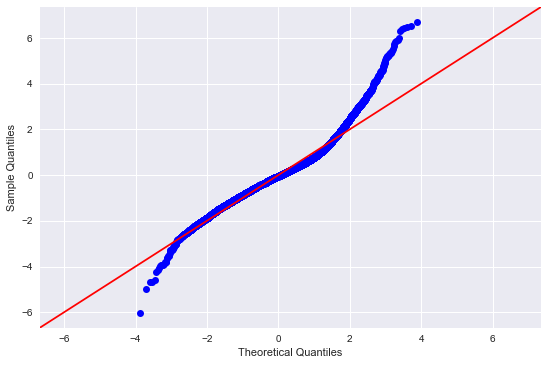

In [136]:
# check QQ Plot for Model5
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

> Not perfect, but definitely a significant improvement over Model 4.

## Model 6 (FINAL)

### Robust Scaler

Considering sqft_living values are in the 1000's while grade is 1 to 13, the model could most likely be improved further by scaling the square-footages down to a magnitude that aligns more closely with the other variables.

In [137]:
# ADDING OUTLIER REMOVAL FROM preprocessing.RobuseScaler
# good to use when you have outliers bc uses median 
from sklearn.preprocessing import RobustScaler

robscaler = RobustScaler()
robscaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [138]:
scale_vars = ['sqft_living']

In [139]:
for col in scale_vars:
    col_data = df[col].values
    res = robscaler.fit_transform(col_data.reshape(-1,1)) # don't scale target
    df['sca_'+col] = res.flatten()

In [140]:
df.describe().round(3)

price   bedrooms  bathrooms  ...  sqft_sums  sqft_diffs  sca_sqft_living
count    21420.000  21420.000  21420.000  ...  21420.000   21420.000        21420.000
mean    541861.428      3.374      2.118  ...   2077.107     291.962            0.146
std     367556.938      0.925      0.769  ...    917.951     442.876            0.820
min      78000.000      1.000      0.500  ...    370.000       0.000           -1.384
25%     324950.000      3.000      1.750  ...   1420.000       0.000           -0.438
50%     450550.000      3.000      2.250  ...   1910.000       0.000            0.000
75%     645000.000      4.000      2.500  ...   2550.000     560.000            0.562
max    7700000.000     33.000      8.000  ...  13540.000    4820.000           10.375

[8 rows x 18 columns]

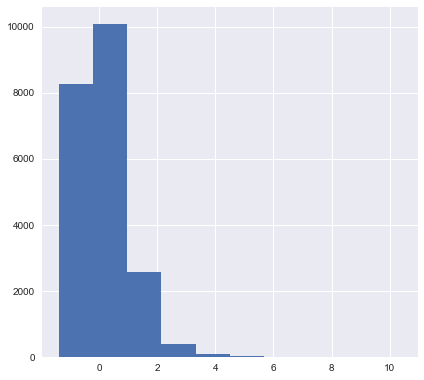

In [141]:
# plot histogram to check normality
df['sca_sqft_living'].hist(figsize=(6,6))

In [142]:
df_zero_outs['sca_sqft_living'] = df['sca_sqft_living'].copy()
df_zero_outs

sqft_living  zipcode  grade     price  sca_sqft_living
0             1180    98178      7  221900.0        -0.660714
1             2570    98125      7  538000.0         0.580357
2              770    98028      6  180000.0        -1.026786
3             1960    98136      7  604000.0         0.035714
4             1680    98074      8  510000.0        -0.214286
...            ...      ...    ...       ...              ...
21592         1530    98103      8  360000.0        -0.348214
21593         2310    98146      8  400000.0         0.348214
21594         1020    98144      7  402101.0        -0.803571
21595         1600    98027      8  400000.0        -0.285714
21596         1020    98144      7  325000.0        -0.803571

[19032 rows x 5 columns]

In [143]:
# rerun OLS with outliers removed
pred6 = ['C(zipcode)', 'C(grade)', 'sca_sqft_living']

# convert to string with + added
f6 = '+'.join(pred6)

# append target
f ='price~'+f6 

# Run model and show sumamry
model = smf.ols(formula=f, data=df_zero_outs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     922.9
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:24   Log-Likelihood:            -2.4420e+05
No. Observations:               19032   AIC:                         4.886e+05
Df Residuals:                   18958   BIC:                         4.891e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.496e+05   5371.330     46.478      0.000    2.39e+05     2.6e+05
C(zipcode)[T.98002]  6351.0940   8273.604      0.768      0.443   -9865.908    2.26e+04
C(zipcode)[T.98003]  9032.9996   7434.520      1.215      0.224   -5539.322    2.36e+04
C(zipcode)[T.98004]  5.348e+05   8930.554     59.882      0.000    5.17e+05    5.52e+05
C(zipcode)[T.98005]  3.542e+05   9156.645     38.683      0.000    3.36e+05    3.72e+05
C(zipcode)[T.98006]  2.922e+05   6944.783     42.071      0.000    2.79e+05    3.06e+05
C(zipcode)[T.98007]  2.603e+05   9524.305     27.331      0.000    2.42e+05    2.79e+05
C(zipcode)[T.98008]  2.605e+05   7415.963     35.126      0.000    2.46e+05    2.75e+05
C(zipcode)[T.98010]  9.544e+04    1.1e+04      8.650      0.000    7.38e+04    1.17e+05
C(zipcode)[T.98011]   1.45e+05   8267.970     17.543      0.000    1.29e+05    1.61e+05
C(zipcode)[T.98014]  1.229e+05   1.01e+04     12.119      0.000    1.03e+05    1.43e+05
C(zipcode)[T.98019]   1.02e+05   8295.019     12.294      0.000    8.57e+04    1.18e+05
C(zipcode)[T.98022]  4.557e+04   7792.524      5.847      0.000    3.03e+04    6.08e+04
C(zipcode)[T.98023] -1.375e+04   6452.171     -2.130      0.033   -2.64e+04   -1099.048
C(zipcode)[T.98024]  1.729e+05   1.21e+04     14.280      0.000    1.49e+05    1.97e+05
C(zipcode)[T.98027]  1.937e+05   6992.109     27.702      0.000     1.8e+05    2.07e+05
C(zipcode)[T.98028]   1.37e+05   7340.785     18.667      0.000    1.23e+05    1.51e+05
C(zipcode)[T.98029]  2.216e+05   7283.822     30.428      0.000    2.07e+05    2.36e+05
C(zipcode)[T.98030]  4581.1771   7556.468      0.606      0.544   -1.02e+04    1.94e+04
C(zipcode)[T.98031]  1.607e+04   7423.110      2.165      0.030    1519.260    3.06e+04
C(zipcode)[T.98032] -1990.2601   9729.845     -0.205      0.838   -2.11e+04    1.71e+04
C(zipcode)[T.98033]  3.304e+05   6905.022     47.845      0.000    3.17e+05    3.44e+05
C(zipcode)[T.98034]  1.871e+05   6333.409     29.544      0.000    1.75e+05       2e+05
C(zipcode)[T.98038]  3.926e+04   6208.414      6.324      0.000    2.71e+04    5.14e+04
C(zipcode)[T.98039]  6.659e+05   4.08e+04     16.315      0.000    5.86e+05    7.46e+05
C(zipcode)[T.98040]  4.608e+05   9085.589     50.714      0.000    4.43e+05    4.79e+05
C(zipcode)[T.98042]  1.535e+04   6287.770      2.442      0.015    3027.646    2.77e+04
C(zipcode)[T.98045]  1.126e+05   8046.330     13.997      0.000    9.69e+04    1.28e+05
C(zipcode)[T.98052]   2.54e+05   6353.557     39.982      0.000    2.42e+05    2.66e+05
C(zipcode)[T.98053]  2.452e+05   6996.748     35.047      0.000    2.32e+05    2.59e+05
C(zipcode)[T.98055]   4.43e+04   7585.387      5.840      0.000    2.94e+04    5.92e+04
C(zipcode)[T.98056]  1.071e+05   6866.303     15.601      0.000    9.37e+04    1.21e+05
C(z

In [144]:
reg_mods['model6'] = {'vars': f6, 'r2': 0.780, 's': 0.766, 'k': 6.241}
reg_mods

{'model1': {'vars': 'grade+sqft_living+bathrooms',
  'r2': 0.536,
  's': 3.293,
  'k': 35.828},
 'model2': {'vars': 'C(zipcode)+grade+sqft_living+sqft_living15+condition_2+condition_3+condition_4+condition_5',
  'r2': 0.75,
  's': 5.17,
  'k': 75.467},
 'model3': {'vars': 'C(zipcode)+grade+sqft_living',
  'r2': 0.744,
  's': 4.927,
  'k': 69.417},
 'model4': {'vars': 'C(zipcode)+C(grade)+sqft_living',
  'r2': 0.783,
  's': 4.032,
  'k': 55.222},
 'model5': {'vars': 'C(zipcode)+C(grade)+sqft_living',
  'r2': 0.78,
  's': 0.766,
  'k': 6.241},
 'model6': {'vars': 'C(zipcode)+C(grade)+sca_sqft_living',
  'r2': 0.78,
  's': 0.766,
  'k': 6.241}}

In [145]:
# save final output
df_fin = df_zero_outs.copy()

with open('data.pickle', 'wb') as f:
    pickle.dump(df_fin, f, pickle.HIGHEST_PROTOCOL)

In [146]:

df_fin.to_csv('kc_housing_model_df_final_data.csv')

# VALIDATION

## K-Fold Validation with OLS

In [147]:
# k_fold_val_ols(X,y,k=10):
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics 


y = df_fin['price']

X = df_fin.drop('price', axis=1)


# Run 10-fold cross validation
results = [['set#','R_square_train','MSE_train','R_square_test','MSE_test']]


num_coeff = X.shape[1]


list_predictors = [str(x) for x in X.columns]
list_predictors.append('intercept') 


reg_params = [list_predictors]


i=0
k=10
while i <(k+1):
    X_train, X_test, y_train, y_test = train_test_split(X,y) #,stratify=[cat_col_names])


    data = pd.concat([X_train,y_train],axis=1)
    f = 'price~C(zipcode)+C(grade)+sca_sqft_living' 
    model = smf.ols(formula=f, data=data).fit()
    model.summary()
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)


    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test


        
    train_mse = metrics.mean_squared_error(y_train, y_hat_train)
    test_mse = metrics.mean_squared_error(y_test, y_hat_test)


    R_sqare_train = metrics.r2_score(y_train,y_hat_train)
    R_square_test = metrics.r2_score(y_test,y_hat_test)


    results.append([i,R_sqare_train,train_mse,R_square_test,test_mse])
    i+=1


    
results = pd.DataFrame(results[1:],columns=results[0])
results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     687.2
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        02:19:36   Log-Likelihood:            -1.8325e+05
No. Observations:               14274   AIC:                         3.666e+05
Df Residuals:                   14200   BIC:                         3.672e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.485e+05   6407.877     38.781      0.000    2.36e+05    2.61e+05
C(zipcode)[T.98002]  7062.4299   9822.317      0.719      0.472   -1.22e+04    2.63e+04
C(zipcode)[T.98003]   1.53e+04   8715.981      1.755      0.079   -1786.501    3.24e+04
C(zipcode)[T.98004]  5.386e+05   1.03e+04     52.377      0.000    5.18e+05    5.59e+05
C(zipcode)[T.98005]  3.573e+05   1.12e+04     31.867      0.000    3.35e+05    3.79e+05
C(zipcode)[T.98006]  2.933e+05   8210.512     35.726      0.000    2.77e+05    3.09e+05
C(zipcode)[T.98007]  2.605e+05   1.13e+04     23.004      0.000    2.38e+05    2.83e+05
C(zipcode)[T.98008]  2.665e+05   8775.517     30.370      0.000    2.49e+05    2.84e+05
C(zipcode)[T.98010]  1.014e+05   1.32e+04      7.698      0.000    7.56e+04    1.27e+05
C(zipcode)[T.98011]   1.52e+05   9764.461     15.567      0.000    1.33e+05    1.71e+05
C(zipcode)[T.98014]  1.326e+05   1.16e+04     11.466      0.000     1.1e+05    1.55e+05
C(zipcode)[T.98019]  9.819e+04   9548.034     10.284      0.000    7.95e+04    1.17e+05
C(zipcode)[T.98022]  4.594e+04   9138.062      5.027      0.000     2.8e+04    6.38e+04
C(zipcode)[T.98023] -8103.0897   7563.819     -1.071      0.284   -2.29e+04    6722.986
C(zipcode)[T.98024]  1.616e+05   1.42e+04     11.387      0.000    1.34e+05    1.89e+05
C(zipcode)[T.98027]  1.924e+05   8362.203     23.014      0.000    1.76e+05    2.09e+05
C(zipcode)[T.98028]  1.444e+05   8601.625     16.785      0.000    1.28e+05    1.61e+05
C(zipcode)[T.98029]  2.286e+05   8554.585     26.722      0.000    2.12e+05    2.45e+05
C(zipcode)[T.98030]  7212.7061   9013.100      0.800      0.424   -1.05e+04    2.49e+04
C(zipcode)[T.98031]  1.978e+04   8610.997      2.297      0.022    2898.951    3.67e+04
C(zipcode)[T.98032]  -934.5494   1.12e+04     -0.084      0.933   -2.29e+04     2.1e+04
C(zipcode)[T.98033]  3.366e+05   8170.535     41.202      0.000    3.21e+05    3.53e+05
C(zipcode)[T.98034]  1.904e+05   7491.507     25.411      0.000    1.76e+05    2.05e+05
C(zipcode)[T.98038]      4e+04   7386.403      5.415      0.000    2.55e+04    5.45e+04
C(zipcode)[T.98039]  6.767e+05    5.3e+04     12.762      0.000    5.73e+05    7.81e+05
C(zipcode)[T.98040]  4.555e+05   1.07e+04     42.734      0.000    4.35e+05    4.76e+05
C(zipcode)[T.98042]  1.676e+04   7499.350      2.235      0.025    2061.588    3.15e+04
C(zipcode)[T.98045]  1.185e+05   9530.245     12.434      0.000    9.98e+04    1.37e+05
C(zipcode)[T.98052]   2.58e+05   7534.102     34.240      0.000    2.43e+05    2.73e+05
C(zipcode)[T.98053]  2.469e+05   8169.617     30.223      0.000    2.31e+05    2.63e+05
C(zipcode)[T.98055]  4.849e+04   8773.847      5.527      0.000    3.13e+04    6.57e+04
C(zipcode)[T.98056]  1.079e+05   8060.888     13.380      0.000    9.21e+04    1.24e+05
C(z

# INTERPRET

> SUMMARY: We can be confident that 78% of the final model (#6) explains the variation in data. Unfortunately, multicollinearity is a significant issue for linear regression and cannot be completely avoided. 


> RECOMMENDATIONS: According to our final model, the best predictors of house prices are sqft-living, zipcode, and grade. 

> * Homes with larger living areas are valued higher than smaller homes. 
> * Houses in certain zip codes are valued at higher prices than other zip codes.
> * Homes that score above at least 8 on Grade will sell higher than those below.

> FUTURE WORK:
> * Identify ranking for zip codes by highest home prices (median home value)
> * Do house prices change over time or depending on season?**
> This data set was limited to a one-year time-frame. I'd be interested in widening the sample size to investigate how property values fluctuate over time as well as how they are affected by market fluctuations.
> * Resold Homes (Duplicate IDs)
> Can we validate the accuracy of our prediction model by looking specifically at houses that resold for a higher price in a given timeframe?** In other words, try to identify which specific variables changed (e.g. increased grade score after doing renovations) and therefore were determining factors in the increased price of the home when it was resold.
>

# `zip_stats()`

In [148]:
# uncomment one or both lines below to install the dependency
# !pip install uszipcode
# !pip install --upgrade uszipcode

In [150]:
# lookup median home value for two zipcodes, Williamstown MA and Los Angeles
zip_stats(zipcodes=['01267','90025'])

{'01267': 293000, '90025': 669100}

In [151]:
# lookup zipcodes in king county dataset with at least $800,000 median value
zip_stats(zipcodes=df.zipcode.unique(), minimum=800000)

{'98040': 864000, '98039': 1000001}